# Setup

In [1]:
# Title: 2.5.1_cmip6_clim.ipynb
# heavily based on https://nordicesmhub.github.io/forces-2021/learning/example-notebooks/xesmf_regridding.html
import warnings
warnings.filterwarnings('ignore') # don't output warnings

import os
# import packages
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xesmf as xe
import pandas as pd
import seaborn as sns
import geopandas as gpd
import rioxarray
import cmcrameri.cm
from scipy.stats import entropy
#import xesmf as xe
import regionmask
import cartopy
import dask
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import fsspec
from dask.diagnostics import progress
from xmip.preprocessing import combined_preprocessing
from collections import defaultdict
regions = gpd.read_file(r'Data\regions1.geojson')


In [2]:
ibge = gpd.read_file(r'D:\GU\IC\Shapes\AtlasMar_BiomasBrasil.shp')
shp_cerrado = ibge[ibge.biomas == 'CERRADO']
ds_knn = xr.open_dataset(r'Data\knn_cerrado3.nc')
ds_knn.rio.write_crs(shp_cerrado.crs, inplace=True)
regions = gpd.read_file(r'Data\regions1.geojson')
gdf_knn = gpd.read_file('Data\gdf_knn_bet.geojson')
palette = sns.color_palette('cmc.batlow', 3)
cerrado_mask = regionmask.Regions([regions.geometry.values[0], regions.geometry.values[1], regions.geometry.values[2]], names=['Central', 'Southern', 'Eastern'], abbrevs=['C', 'S', 'E'], name = 'Cerrado Regions')


In [3]:
bests = ['ACCESS-CM2','CESM2-WACCM','GFDL-CM4','GFDL-ESM4','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','HadGEM3-GC31-LL']
all_models= ['ACCESS-CM2', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0',
   'CAS-ESM2-0', 'CESM2-WACCM', 'CanESM5', 'E3SM-1-1', 'FGOALS-f3-L',
   'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'IITM-ESM',
   'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM',
   'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3',
   'NorESM2-MM']


In [4]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')


# test 

In [135]:
expts = ['ssp245']#'ssp
var = ['tas']
query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id=var,
    member_id = 'r1i1p1f1',
    source_id = bests
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()
dset_dict = col_subset.to_dataset_dict(zarr_kwargs={'use_cftime':True})

#hadgem
query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id=var,
    member_id = 'r1i1p1f3',
    source_id = ['HadGEM3-GC31-LL']
   
)

col_subset_had = col.search(require_all_on=["source_id"], **query)
col_subset_had.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()
dset_dict_had = col_subset_had.to_dataset_dict(zarr_kwargs={'use_cftime':True})

dset_dict[list(dset_dict_had.keys())[-1]] = dset_dict_had[list(dset_dict_had.keys())[-1]]



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


<GeoAxesSubplot: title={'center': 'time = 1850-01-16 00:00:00'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

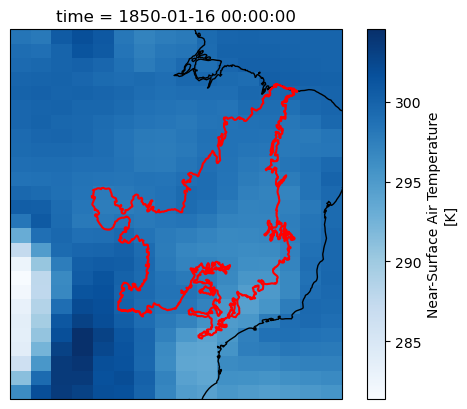

In [53]:
ax = plt.axes(projection=ccrs.PlateCarree(), frameon=True)
ax.coastlines()
ds.isel(time=0)[var].plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues')
shp_cerrado.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='red')

In [136]:
ds = dset_dict[list(dset_dict.keys())[-1]]
cords = [i for i in ds.coords]
dropss = set(cords) - set(['lat', 'lon', 'time'])
ds_out= ds.sel(time=slice('1850', '2100'), lat=slice(-30, 2), lon=slice(292, 322)).squeeze().drop(dropss)


In [141]:
ds_regrid_dict = dict()
for key in dset_dict.keys():
    print(key)
    ds_in = dset_dict[key].sortby('time')
    #print(ds_in.dims)
    cords = [i for i in ds_in.coords]
    dropss = set(cords) - set(['lat', 'lon', 'time'])
    ds_in= ds_in.sel(time=slice('1850', '2100'), lat=slice(-30, 2), lon=slice(292, 322)).squeeze().drop(dropss)
#
    ds_in['time'] = ds_out['time']
    regridder = xe.Regridder(ds_in, ds_out[['lat','lon']], 'bilinear')
    ds_in_regrid = regridder(ds_in, keep_attrs=True)
    model = key.split('.')[2]
#
    # create dataset with all models
    ds_regrid_dict[model] = ds_in_regrid


ScenarioMIP.MIROC.MIROC6.ssp245.Amon.gn
ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp245.Amon.gn
ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp245.Amon.gn
ScenarioMIP.MRI.MRI-ESM2-0.ssp245.Amon.gn
ScenarioMIP.DKRZ.MPI-ESM1-2-HR.ssp245.Amon.gn
ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp245.Amon.gr1
ScenarioMIP.NCAR.CESM2-WACCM.ssp245.Amon.gn
ScenarioMIP.NOAA-GFDL.GFDL-CM4.ssp245.Amon.gr1
ScenarioMIP.MOHC.HadGEM3-GC31-LL.ssp245.Amon.gn


In [142]:
_ds = list(ds_regrid_dict.values())
_coord = list(ds_regrid_dict.keys())
ds_out_regrid = xr.concat(objs=_ds, dim=_coord, coords='minimal',compat='override').rename({'concat_dim':'model'})
ds_out_regrid

<xarray.Dataset>
Dimensions:  (model: 9, time: 1032, lat: 26, lon: 16)
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lat      (lat) float64 -29.38 -28.12 -26.88 -25.62 ... -0.625 0.625 1.875
  * lon      (lon) float64 293.4 295.3 297.2 299.1 ... 315.9 317.8 319.7 321.6
  * model    (model) object 'MIROC6' 'ACCESS-CM2' ... 'HadGEM3-GC31-LL'
Data variables:
    tas      (model, time, lat, lon) float32 dask.array<chunksize=(1, 480, 26, 16), meta=np.ndarray>
Attributes: (12/61)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             60265.0
    branch_time_in_parent:            60265.0
    cmor_version:                     3.4.0
    ...                               ...
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/ScenarioMIP/MIROC/MIRO...
    intake_esm_attrs:version:         20190627
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           ScenarioMIP.MIROC.MIROC6.ssp245.Amon.gn
    regrid_method:                    bilinear

In [144]:
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time', 'model'}
    return (ds * weight).mean(other_dims)


In [145]:
#mask and apply annual mean.
mask = cerrado_mask.mask(ds_out_regrid, lon_name='lon', lat_name='lat')
ds_out_regrid['mask'] = mask


In [146]:
ds_mean_month = ds_out_regrid.groupby('mask').apply(global_mean)

In [106]:
ds_mean_month_a = dask.compute(ds_mean_month)[0]
ds_mean_month_a['experiment'] = expts

In [156]:
ds_mean_month_a = ds_mean_month_a.drop('year')

In [150]:
ds_mean_month_b = dask.compute(ds_mean_month)[0]
ds_mean_month_b['experiment'] = expts

In [175]:
#merge datasets
dss = xr.concat([ds_mean_month_a, ds_mean_month_b], dim='experiment')
dss['year'] = dss.time.dt.year

In [201]:
#resample sum for each season in each year
dss.coarsen(time=3).sum().time.dt.season.values

array(['DJF', 'MAM', 'JJA', ..., 'MAM', 'JJA', 'SON'], dtype='<U3')

In [184]:
dff = dss.swap_dims({'time':'year'}).coarsen(year=12).mean().rolling(year=10).mean().to_dataframe().reset_index().dropna()

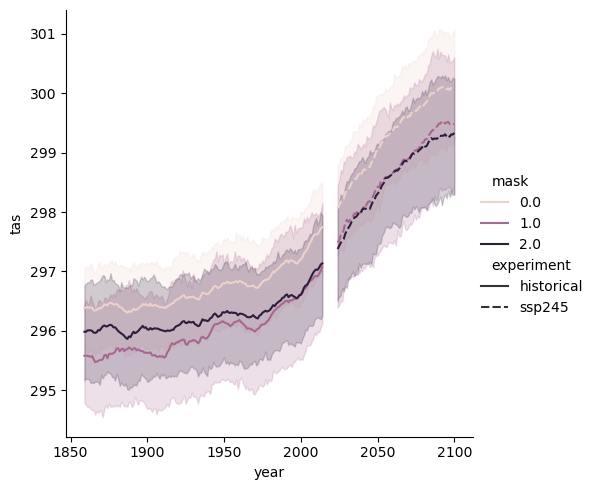

In [185]:
sns.relplot(x='year', y='tas', style='experiment', hue='mask', data=dff, kind='line')

In [206]:
ds_season = dss.coarsen(time=3).mean()
ds_season['season'] = ds_season.time.dt.season

In [209]:
dfs = ds_season.swap_dims({'time':'season'}).to_dataframe().reset_index().dropna()

# function

In [5]:
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds, dim_out = 'time'):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {dim_out , 'model'}
    return (ds * weight).mean(other_dims)

In [6]:
def ensemble_models(expt, models, var='pr'):
    """
    Function to get data from models and ensemble members
    """
    query = dict(
        experiment_id=expt,
        table_id='Amon',
        variable_id=[var],
        member_id = 'r1i1p1f1',
        source_id = models
    )

    col_subset = col.search(require_all_on=["source_id"], **query)
    col_subset.df.groupby("source_id")[
        ["experiment_id", "variable_id", "table_id"]
    ].nunique()
    dset_dict = col_subset.to_dataset_dict(zarr_kwargs={'use_cftime':True})

    # add HADGEM
    query = dict(
    experiment_id=expt,
    table_id='Amon',
    variable_id=[var],
    member_id = 'r1i1p1f3',
    source_id = ['HadGEM3-GC31-LL']
   
    )

    col_subset_had = col.search(require_all_on=["source_id"], **query)

    dset_dict_had = col_subset_had.to_dataset_dict(zarr_kwargs={'use_cftime':True})
    dset_dict[list(dset_dict_had)[-1]] = dset_dict_had[list(dset_dict_had)[-1]]
    return dset_dict

In [7]:
def regrid_models_ts(ensemble,  grid_out):
    ds = ensemble[grid_out]
    cords = [i for i in ds.coords]
    dropss = set(cords) - set(['lat', 'lon', 'time'])
    ds_out= ds.sel(time=slice('1850', '2100'), lat=slice(-30, 2), lon=slice(292, 322)).squeeze().drop(dropss)

    ds_regrid_dict = dict()
    for key in ensemble.keys():
    
        ds_in = ensemble[key].sortby('time')
        #print(ds_in.dims)
        cords = [i for i in ds_in.coords]
        dropss = set(cords) - set(['lat', 'lon', 'time'])
        ds_in= ds_in.sel(time=slice('1850', '2100'), lat=slice(-30, 2), lon=slice(292, 322)).squeeze().drop(dropss)
 
        ds_in['time'] = ds_out['time']
        regridder = xe.Regridder(ds_in, ds_out[['lat','lon']], 'bilinear')
        ds_in_regrid = regridder(ds_in, keep_attrs=True)
        model = key.split('.')[2]

        # create dataset with all models
        ds_regrid_dict[model] = ds_in_regrid

    _ds = list(ds_regrid_dict.values())
    _coord = list(ds_regrid_dict.keys())
    ds_out_regrid = xr.concat(objs=_ds, dim=_coord, coords='minimal',compat='override').rename({'concat_dim':'model'})
    dims_out = set(ds_out_regrid.dims) - {'lat', 'lon', 'model', 'time'}
    ds_regrids= ds_out_regrid.drop_dims(dims_out)
    
   
    return ds_regrids

In [8]:
expt = 'historical'
models = bests
var = 'pr'

In [70]:
def month_mean_ts(variable, models):
    ds_list = []
    for expt in ['historical', 'ssp245', 'ssp585']:
        dset_dict = ensemble_models(expt, models , var = variable)
        ds_regridss = regrid_models_ts(dset_dict, list(dset_dict)[-1])
        mask = cerrado_mask.mask(ds_regridss, lon_name='lon', lat_name='lat')
        ds_regridss['mask'] = mask
        ds_mean_month = ds_regridss.groupby('mask').apply(global_mean)
        ds_mean_month['experiment'] = expt
        ds_mean_month_a = dask.compute(ds_mean_month)[0]
        ds_list.append(ds_mean_month_a)
    
    dss = xr.concat(ds_list, dim='experiment')
    return dss

# datasets

In [242]:
ds_ts_pr = month_mean_ts('pr', bests)
ds_ts_pr['pr'] = ds_ts_pr['pr'] *86400*30
ds_ts_pr.to_netcdf(r'Data\CMIP6\timeseries\pr_ts_month_bests.nc')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [245]:
ds_ts_tas = month_mean_ts('tas', bests)
ds_ts_tas['tas'] = ds_ts_tas['tas'] - 273.15
ds_ts_tas.to_netcdf(r'Data\CMIP6\timeseries\tas_ts_month_bests.nc')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [247]:
ds_ts_hurs = month_mean_ts('hurs', bests)
ds_ts_hurs.to_netcdf(r'Data\CMIP6\timeseries\hurs_ts_month_bests.nc')


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


## entropy

In [9]:
def yearly_ratio(x):
    return x / (x.mean(dim='time')*12)

In [18]:
ds_list = []
uniform = np.zeros((9, 12, 26, 16))
uniform[:] = 1/12
for expt in ['historical', 'ssp245', 'ssp585']:
    print(expt)
    dset_dict = ensemble_models(expt, models , var = 'pr')
    ds_regridss = regrid_models_ts(dset_dict, list(dset_dict)[-1])
    ds_regridss.coords['year'] = ds_regridss.time.dt.year
    ds_regridss['ratio']= ds_regridss.groupby('time.year').apply(yearly_ratio).pr
    print('loading data')
    ds_regridss = ds_regridss.drop('pr').load()
    ds_regridss['entropy'] = ds_regridss.ratio.groupby('time.year').reduce(entropy, qk = uniform, base=2, dim='time')
    print('calculating mask')
    mask = cerrado_mask.mask(ds_regridss, lon_name='lon', lat_name='lat')
    ds_regridss['mask'] = mask
    ds_regridss = ds_regridss.drop(['ratio'])
    ds_mean_month = ds_regridss.groupby('mask').apply(global_mean, dim_out='year')
    ds_mean_month['experiment'] = expt
    ds_list.append(ds_mean_month)
    print('done')

dss = xr.concat(ds_list, dim='experiment')    

historical

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


loading data
calculating mask
done
ssp245


loading data
calculating mask
done
ssp585


loading data
calculating mask
done


In [33]:
dss.sel(experiment=0)

<xarray.Dataset>
Dimensions:  (model: 9, year: 251, mask: 3)
Coordinates:
  * model    (model) object 'ACCESS-CM2' 'CESM2-WACCM' ... 'MRI-ESM2-0'
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
  * mask     (mask) float64 0.0 1.0 2.0
Data variables:
    entropy  (mask, model, year) float64 0.6859 0.6257 0.6986 ... nan nan nan

In [36]:
#change experiment values from 0, 1, 2 to historical, ssp245, ssp585
dss['experiment'] = ['historical', 'ssp245', 'ssp585']

In [41]:
#save the data
dss.to_netcdf(r'Data\CMIP6\timeseries\ent_ts_yearly_bests.nc')

### test

In [6]:
expt = 'historical'
models = bests

In [11]:
dset_dict = ensemble_models(expt, models , var = 'pr')
ds_regridss = regrid_models_ts(dset_dict, list(dset_dict)[-1])
ds_regridss.coords['year'] = ds_regridss.time.dt.year
ds_regridss['ratio']= ds_regridss.groupby('time.year').apply(yearly_ratio).pr
uniform = np.zeros((9, 12, 26, 16))
uniform[:] = 1/12
ds_regridss = ds_regridss.drop('pr').load()
ds_regridss['entropy'] = ds_regridss.ratio.groupby('time.year').reduce(entropy, qk = uniform, base=2, dim='time')
mask = cerrado_mask.mask(ds_regridss, lon_name='lon', lat_name='lat')
ds_regridss['mask'] = mask
ds_regridss = ds_regridss.drop(['ratio'])
ds_mean_month = ds_regridss.groupby('mask').apply(global_mean, dim_out='year') 


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


## VPD

In [8]:
def vpd(temp, rh):
    return 0.6108 * np.exp((17.27 * temp) / (temp + 237.3)) * (1 - rh/100)

In [38]:
#tas e RH, calcular os 2.
ds_list = []
for expt in ['historical', 'ssp245', 'ssp585']:
    print(expt)
    dset_dict_tas = ensemble_models(expt, models , var = 'tas')
    ds_regridss_tas = regrid_models_ts(dset_dict_tas, list(dset_dict_tas)[-1])
    dset_dict_hurs = ensemble_models(expt, models , var = 'hurs')
    ds_regridss_hurs = regrid_models_ts(dset_dict_hurs, list(dset_dict_hurs)[-1])
    ds_regridss_tas['tas'] = ds_regridss_tas.tas - 273.15

    ds_regridss_hurs['vpd'] = vpd(ds_regridss_tas.tas, ds_regridss_hurs.hurs)
    ds_regridss = ds_regridss_hurs.drop(['hurs'])
    mask = cerrado_mask.mask(ds_regridss, lon_name='lon', lat_name='lat')
    ds_regridss['mask'] = mask
    ds_mean_month = ds_regridss.groupby('mask').apply(global_mean)
    ds_mean_month['experiment'] = expt
    ds_mean_month_a = dask.compute(ds_mean_month)[0]
    ds_list.append(ds_mean_month_a)

dss = xr.concat(ds_list, dim='experiment')        

historical

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


ssp245


ssp585


In [40]:
#save
dss.to_netcdf(r'Data\CMIP6\timeseries\vpd_ts_month_bests.nc')

## test

In [18]:
expt = 'historical'

In [34]:

dset_dict_tas = ensemble_models(expt, models , var = 'tas')
ds_regridss_tas = regrid_models_ts(dset_dict_tas, list(dset_dict_tas)[-1])
ds_regridss_tas['tas'] = ds_regridss_tas.tas - 273.15
dset_dict_hurs = ensemble_models(expt, models , var = 'hurs')
ds_regridss_hurs = regrid_models_ts(dset_dict_hurs, list(dset_dict_hurs)[-1])
ds_regridss_hurs['vpd'] = vpd(ds_regridss_tas.tas, ds_regridss_hurs.hurs)
ds_regridss = ds_regridss_hurs.drop(['hurs'])



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [35]:
mask = cerrado_mask.mask(ds_regridss, lon_name='lon', lat_name='lat')
ds_regridss['mask'] = mask


In [36]:
ds_regridss = dask.compute(ds_regridss)[0]
ds_mean_month = ds_regridss.groupby('mask').apply(global_mean)
ds_mean_month['experiment'] = expt
#ds_mean_month_a = dask.compute(ds_mean_month)[0]



# DF

In [42]:
#open datasets
ds_ts_pr = xr.open_dataset(r'Data\CMIP6\timeseries\pr_ts_month_bests.nc', chunks='auto')
ds_ts_tas = xr.open_dataset(r'Data\CMIP6\timeseries\tas_ts_month_bests.nc',chunks='auto')
ds_ts_hurs = xr.open_dataset(r'Data\CMIP6\timeseries\hurs_ts_month_bests.nc',chunks='auto')
ds_ts_vpd = xr.open_dataset(r'Data\CMIP6\timeseries\vpd_ts_month_bests.nc',chunks='auto')
##
ds_ts_ent = xr.open_dataset(r'Data\CMIP6\timeseries\ent_ts_yearly_bests.nc',chunks='auto')

In [100]:
def ds_to_df_plot(ds, window=10):
    df = ds.rolling(year=window).mean().to_dataframe().reset_index().dropna()
    df['mask'].replace({0:'Central', 1:'Southern', 2:'Eastern'}, inplace=True)
    df.rename(columns={'mask':'Region', 'experiment':'Experiment'}, inplace=True)
    df['Experiment'].replace({'historical':'Historical', 'ssp245':'SSP2-4.5', 'ssp585':'SSP5-8.5'}, inplace=True)
    return df

In [23]:
def ds_yearly(ds):
    ds['year'] = ds.time.dt.year
    return ds.swap_dims({'time':'year'}).coarsen(year=12).mean()

## anual

In [24]:
df_pr = ds_to_df_plot(ds_yearly(ds_ts_pr))
df_pr['pr'] = df_pr['pr'] * 12
df_tas = ds_to_df_plot(ds_yearly(ds_ts_tas))
df_hurs = ds_to_df_plot(ds_yearly(ds_ts_hurs))
df_vpd = ds_to_df_plot(ds_yearly(ds_ts_vpd))

In [27]:
df_pr.to_csv(r'Data\CMIP6\timeseries\df_pr_ts_year_10_bests.csv')
df_tas.to_csv(r'Data\CMIP6\timeseries\df_tas_ts_year_10_bests.csv')
df_hurs.to_csv(r'Data\CMIP6\timeseries\df_hurs_ts_year_10_bests.csv')
df_vpd.to_csv(r'Data\CMIP6\timeseries\df_vpd_ts_year_10_bests.csv')

In [43]:
df_ent = ds_to_df_plot(ds_ts_ent)
df_ent.to_csv(r'Data\CMIP6\timeseries\df_ent_ts_year_10_bests.csv')

### anomaly

In [49]:
def ds_anomaly(ds):
    #ds_y = ds_yearly(ds)
    ds_anom = (ds - ds.sel(experiment='historical').sel(year=slice(1981, 2010)).mean('year'))
    return ds_anom

In [50]:
#create dfs
df_pr_anom = ds_to_df_plot(ds_anomaly(ds_yearly(ds_ts_pr)))
df_pr_anom['pr'] = df_pr_anom['pr'] * 12
df_tas_anom = ds_to_df_plot(ds_anomaly(ds_yearly(ds_ts_tas)))
df_hurs_anom = ds_to_df_plot(ds_anomaly(ds_yearly(ds_ts_hurs)))
df_vpd_anom = ds_to_df_plot(ds_anomaly(ds_yearly(ds_ts_vpd)))

#entropy
df_ent_anom = ds_to_df_plot(ds_anomaly(ds_ts_ent))




In [51]:
#save dfs
df_pr_anom.to_csv(r'Data\CMIP6\timeseries\df_pr_anom_ts_year_10_bests.csv')
df_tas_anom.to_csv(r'Data\CMIP6\timeseries\df_tas_anom_ts_year_10_bests.csv')
df_hurs_anom.to_csv(r'Data\CMIP6\timeseries\df_hurs_anom_ts_year_10_bests.csv')
df_vpd_anom.to_csv(r'Data\CMIP6\timeseries\df_vpd_anom_ts_year_10_bests.csv')
df_ent_anom.to_csv(r'Data\CMIP6\timeseries\df_ent_anom_ts_year_10_bests.csv')

### ratio

In [52]:
def ds_ratio(ds):
    ds_clim = ds.sel(experiment='historical').sel(year=slice(1981, 2010)).mean('year')
    ds_ratio = (ds - ds_clim) / ds_clim
    return ds_ratio*100

In [53]:
# create dfs
df_pr_ratio = ds_to_df_plot(ds_ratio(ds_yearly(ds_ts_pr)))
df_tas_ratio = ds_to_df_plot(ds_ratio(ds_yearly(ds_ts_tas)))
df_hurs_ratio = ds_to_df_plot(ds_ratio(ds_yearly(ds_ts_hurs)))
df_vpd_ratio = ds_to_df_plot(ds_ratio(ds_yearly(ds_ts_vpd)))

#entropy
df_ent_ratio = ds_to_df_plot(ds_ratio(ds_ts_ent))


In [54]:
#save dfs
df_pr_ratio.to_csv(r'Data\CMIP6\timeseries\df_pr_ratio_ts_year_10_bests.csv')
df_tas_ratio.to_csv(r'Data\CMIP6\timeseries\df_tas_ratio_ts_year_10_bests.csv')
df_hurs_ratio.to_csv(r'Data\CMIP6\timeseries\df_hurs_ratio_ts_year_10_bests.csv')
df_vpd_ratio.to_csv(r'Data\CMIP6\timeseries\df_vpd_ratio_ts_year_10_bests.csv')
df_ent_ratio.to_csv(r'Data\CMIP6\timeseries\df_ent_ratio_ts_year_10_bests.csv')

## seasonal

In [103]:
ds_ts_pr = xr.open_dataset(r'Data\CMIP6\timeseries\pr_ts_month_bests.nc', chunks='auto')
ds_ts_tas = xr.open_dataset(r'Data\CMIP6\timeseries\tas_ts_month_bests.nc',chunks='auto')
ds_ts_hurs = xr.open_dataset(r'Data\CMIP6\timeseries\hurs_ts_month_bests.nc',chunks='auto')
ds_ts_vpd = xr.open_dataset(r'Data\CMIP6\timeseries\vpd_ts_month_bests.nc',chunks='auto')

In [104]:
def ds_season_plot(ds):
    ds['season'] = ds['time.season']
    ds_season = ds.groupby('time.season').apply(lambda x: x.groupby('time.year').mean(dim='time')).load()
    return ds_season

In [105]:
ds_pr_season = ds_season_plot(ds_ts_pr)
df_pr_season = ds_to_df_plot(ds_pr_season)
ds_ts_tas_season = ds_season_plot(ds_ts_tas)
df_tas_season = ds_to_df_plot(ds_ts_tas_season)
ds_ts_hurs_season = ds_season_plot(ds_ts_hurs)
df_hurs_season = ds_to_df_plot(ds_ts_hurs_season)
ds_ts_vpd_season = ds_season_plot(ds_ts_vpd)
df_vpd_season = ds_to_df_plot(ds_ts_vpd_season)



In [111]:
# save dfs
df_pr_season.to_csv(r'Data\CMIP6\timeseries\df_pr_ts_season_10_bests.csv')
df_tas_season.to_csv(r'Data\CMIP6\timeseries\df_tas_ts_season_10_bests.csv')
df_hurs_season.to_csv(r'Data\CMIP6\timeseries\df_hurs_ts_season_10_bests.csv')
df_vpd_season.to_csv(r'Data\CMIP6\timeseries\df_vpd_ts_season_10_bests.csv')


### anomalies

In [112]:
def ds_anomaly(ds):
    #ds_y = ds_yearly(ds)
    ds_anom = (ds - ds.sel(experiment='historical').sel(year=slice(1981, 2010)).mean('year'))
    return ds_anom

In [120]:
df_pr_season_anom = ds_to_df_plot(ds_anomaly(ds_pr_season))
df_tas_season_anom = ds_to_df_plot(ds_anomaly(ds_ts_tas_season))
df_hurs_season_anom = ds_to_df_plot(ds_anomaly(ds_ts_hurs_season))
df_vpd_season_anom = ds_to_df_plot(ds_anomaly(ds_ts_vpd_season))

In [121]:
# save dfs
df_pr_season_anom.to_csv(r'Data\CMIP6\timeseries\df_pr_anom_ts_season_10_bests.csv')
df_tas_season_anom.to_csv(r'Data\CMIP6\timeseries\df_tas_anom_ts_season_10_bests.csv')
df_hurs_season_anom.to_csv(r'Data\CMIP6\timeseries\df_hurs_anom_ts_season_10_bests.csv')
df_vpd_season_anom.to_csv(r'Data\CMIP6\timeseries\df_vpd_anom_ts_season_10_bests.csv')

# plots

## anual

In [60]:
#get only data after 1940
df_pr = df_pr[df_pr['year'] >= 1940]
df_tas = df_tas[df_tas['year'] >= 1940]
df_hurs = df_hurs[df_hurs['year'] >= 1940]
df_vpd = df_vpd[df_vpd['year'] >= 1940]
df_ent = df_ent[df_ent['year'] >= 1940]

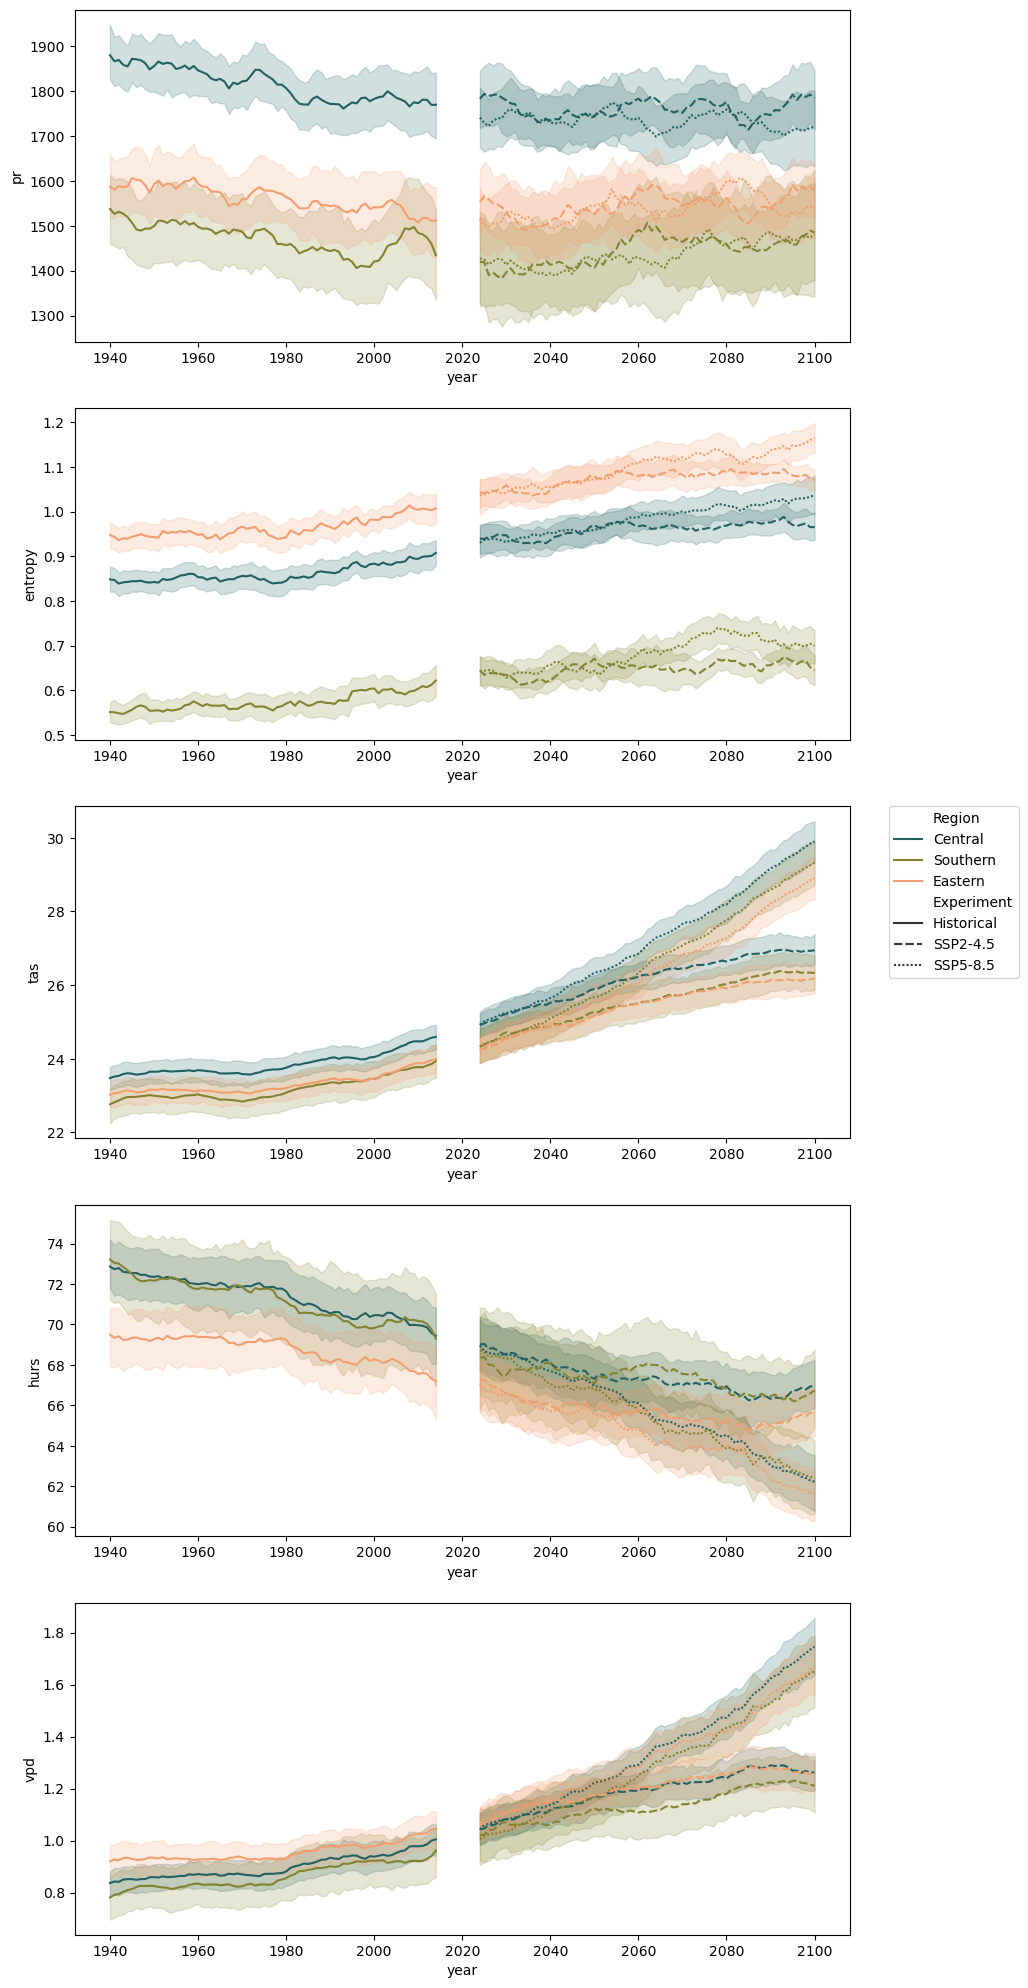

In [70]:
#plot all the dfs in a subplot
fig, ax = plt.subplots(5,1, figsize=(10,25))

sns.lineplot(data=df_pr, x='year', y='pr', hue='Region', ax=ax[0], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_ent, x='year', y='entropy', hue='Region', ax=ax[1], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_tas, x='year', y='tas', hue='Region', ax=ax[2], palette=palette, errorbar=('ci', 60), style='Experiment')
sns.lineplot(data=df_hurs, x='year', y='hurs', hue='Region', ax=ax[3], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_vpd, x='year', y='vpd', hue='Region', ax=ax[4], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
# legend outside of plot
ax[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### anomaly

In [66]:
#get only data after 1940
df_pr_anom = df_pr_anom[df_pr_anom['year'] >= 1940]
df_tas_anom = df_tas_anom[df_tas_anom['year'] >= 1940]
df_hurs_anom = df_hurs_anom[df_hurs_anom['year'] >= 1940]
df_vpd_anom = df_vpd_anom[df_vpd_anom['year'] >= 1940]
df_ent_anom = df_ent_anom[df_ent_anom['year'] >= 1940]


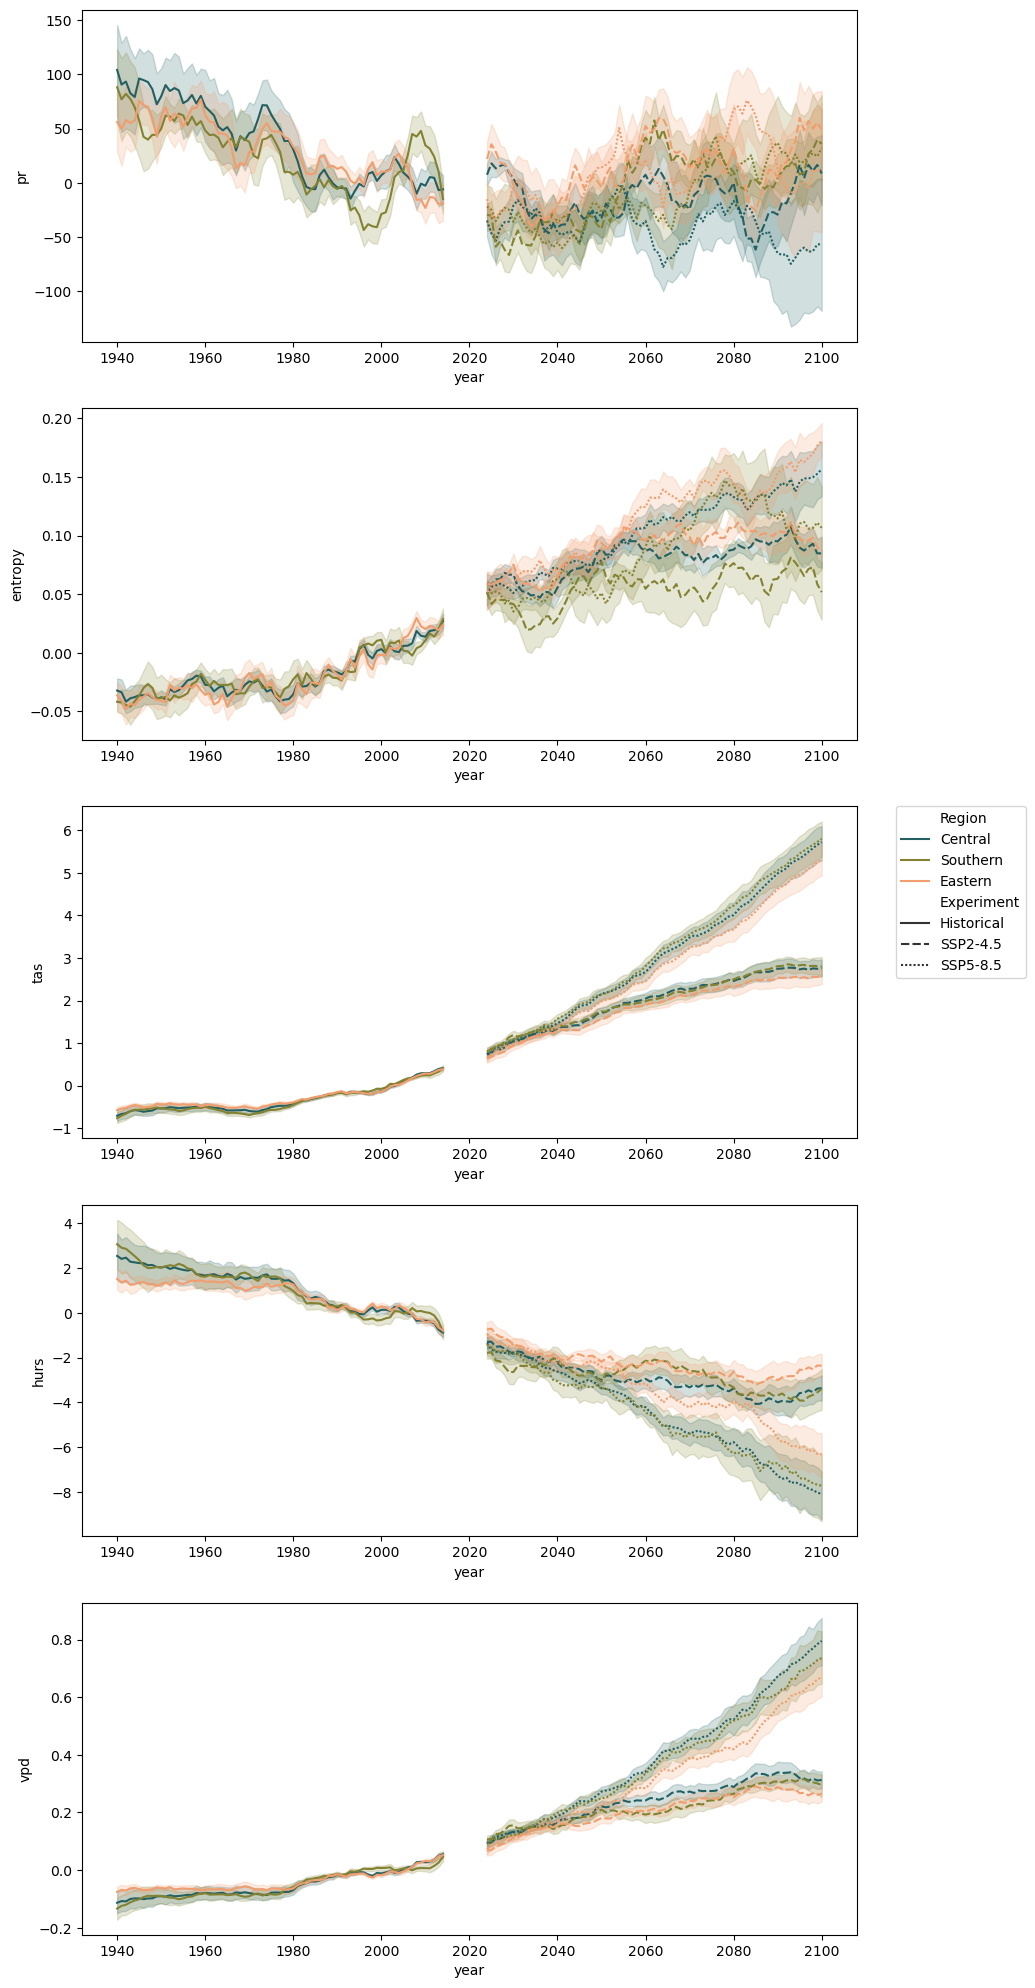

In [71]:
#plot all the dfs in a subplot
fig, ax = plt.subplots(5,1, figsize=(10,25))
sns.lineplot(data=df_pr_anom, x='year', y='pr', hue='Region', ax=ax[0], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_ent_anom, x='year', y='entropy', hue='Region', ax=ax[1], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_tas_anom, x='year', y='tas', hue='Region', ax=ax[2], palette=palette, errorbar=('ci', 60), style='Experiment')
sns.lineplot(data=df_hurs_anom, x='year', y='hurs', hue='Region', ax=ax[3], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_vpd_anom, x='year', y='vpd', hue='Region', ax=ax[4], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
# legend outside of plot
ax[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### ratio

In [68]:
#get only data after 1940
df_pr_ratio = df_pr_ratio[df_pr_ratio['year'] >= 1940]
df_tas_ratio = df_tas_ratio[df_tas_ratio['year'] >= 1940]
df_hurs_ratio = df_hurs_ratio[df_hurs_ratio['year'] >= 1940]
df_vpd_ratio = df_vpd_ratio[df_vpd_ratio['year'] >= 1940]
df_ent_ratio = df_ent_ratio[df_ent_ratio['year'] >= 1940]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


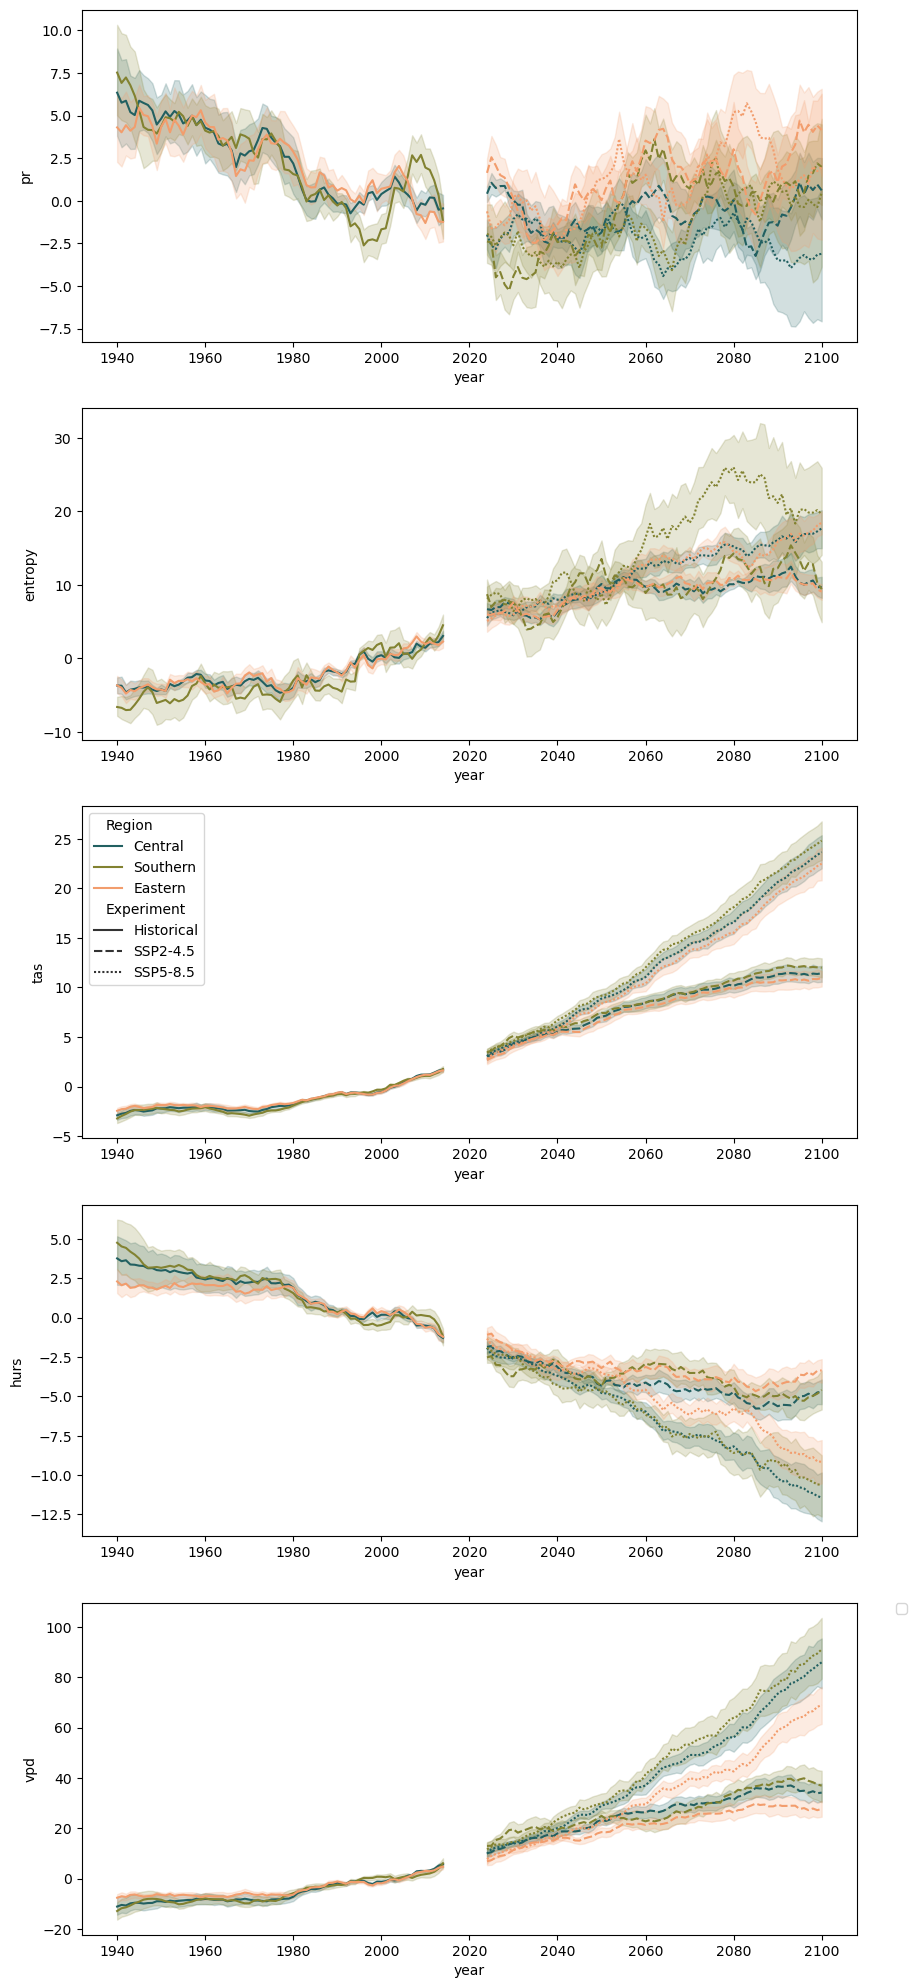

In [69]:
# plot all the dfs in a subplot
fig, ax = plt.subplots(5,1, figsize=(10,25))
sns.lineplot(data=df_pr_ratio, x='year', y='pr', hue='Region', ax=ax[0], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_ent_ratio, x='year', y='entropy', hue='Region', ax=ax[1], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_tas_ratio, x='year', y='tas', hue='Region', ax=ax[2], palette=palette, errorbar=('ci', 60), style='Experiment')
sns.lineplot(data=df_hurs_ratio, x='year', y='hurs', hue='Region', ax=ax[3], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_vpd_ratio, x='year', y='vpd', hue='Region', ax=ax[4], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## seasonal

In [106]:
# get only data after 1940
df_pr_season = df_pr_season[df_pr_season['year'] >= 1940]
df_tas_season = df_tas_season[df_tas_season['year'] >= 1940]
df_hurs_season = df_hurs_season[df_hurs_season['year'] >= 1940]
df_vpd_season = df_vpd_season[df_vpd_season['year'] >= 1940]

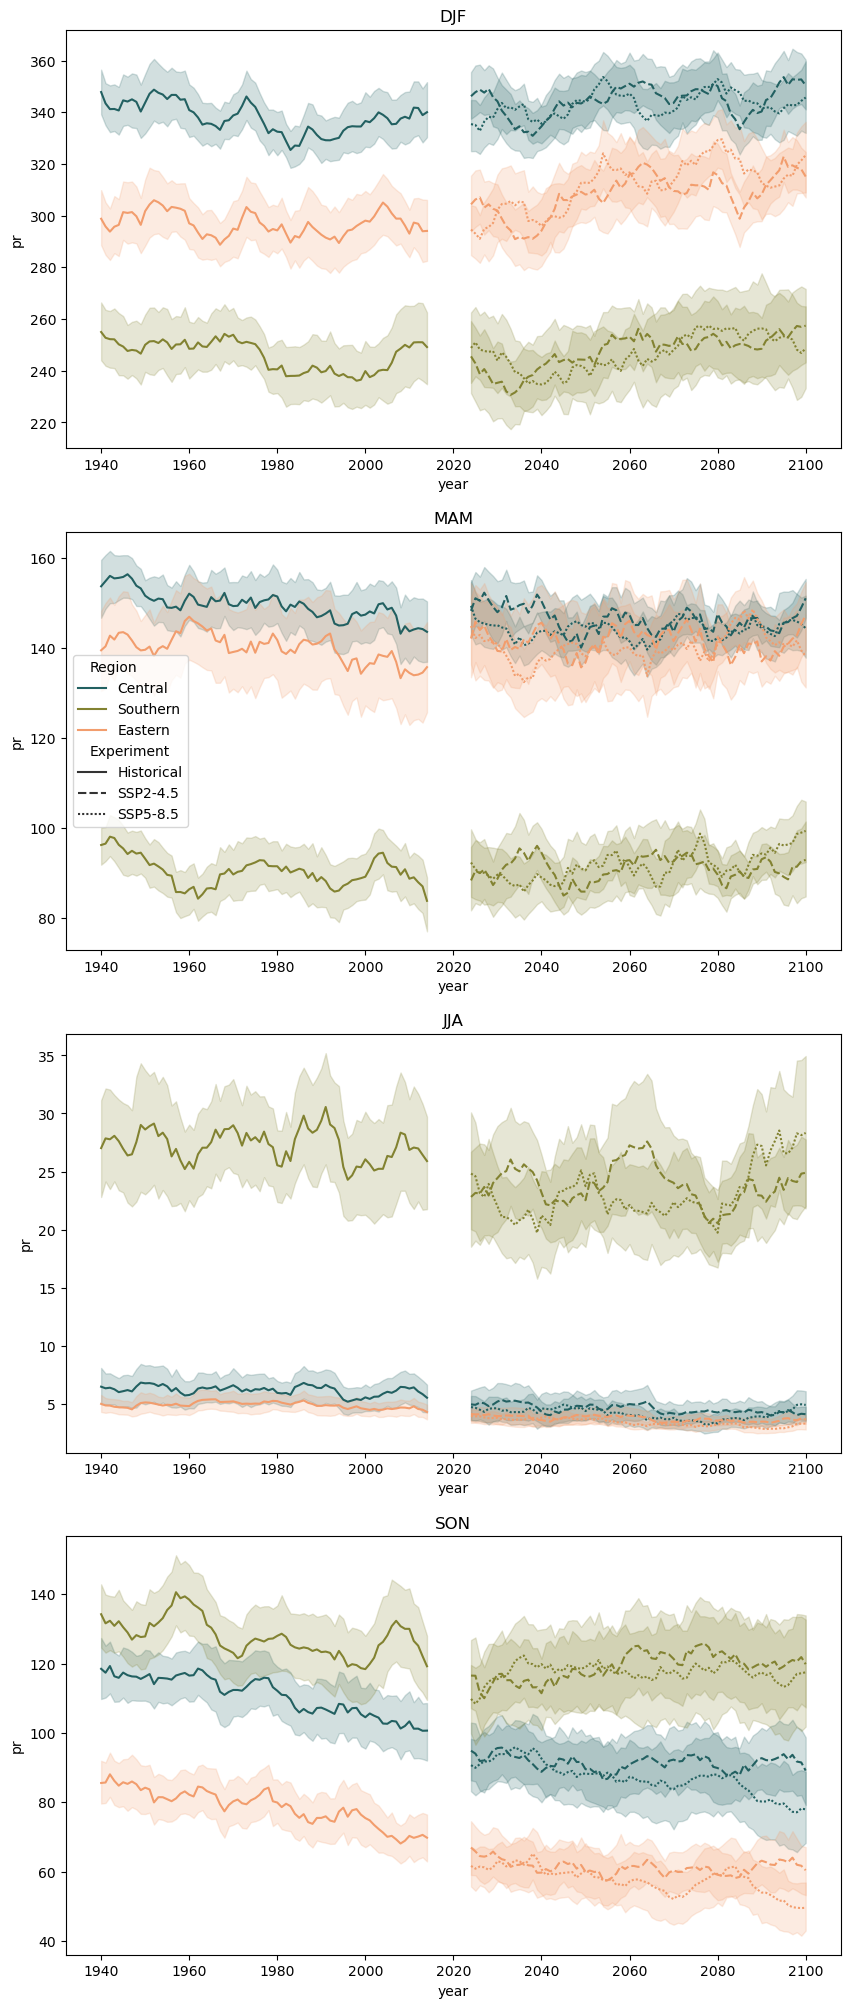

In [107]:
# plot time series for each season
fig, ax = plt.subplots(4,1, figsize=(10,25))
sns.lineplot(data=df_pr_season[df_pr_season['season']=='DJF'], x='year', y='pr', hue='Region', ax=ax[0], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_pr_season[df_pr_season['season']=='MAM'], x='year', y='pr', hue='Region', ax=ax[1], palette=palette, errorbar=('ci', 60), style='Experiment', legend=True)
sns.lineplot(data=df_pr_season[df_pr_season['season']=='JJA'], x='year', y='pr', hue='Region', ax=ax[2], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_pr_season[df_pr_season['season']=='SON'], x='year', y='pr', hue='Region', ax=ax[3], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
ax[0].title.set_text('DJF')
ax[1].title.set_text('MAM')
ax[2].title.set_text('JJA')
ax[3].title.set_text('SON')



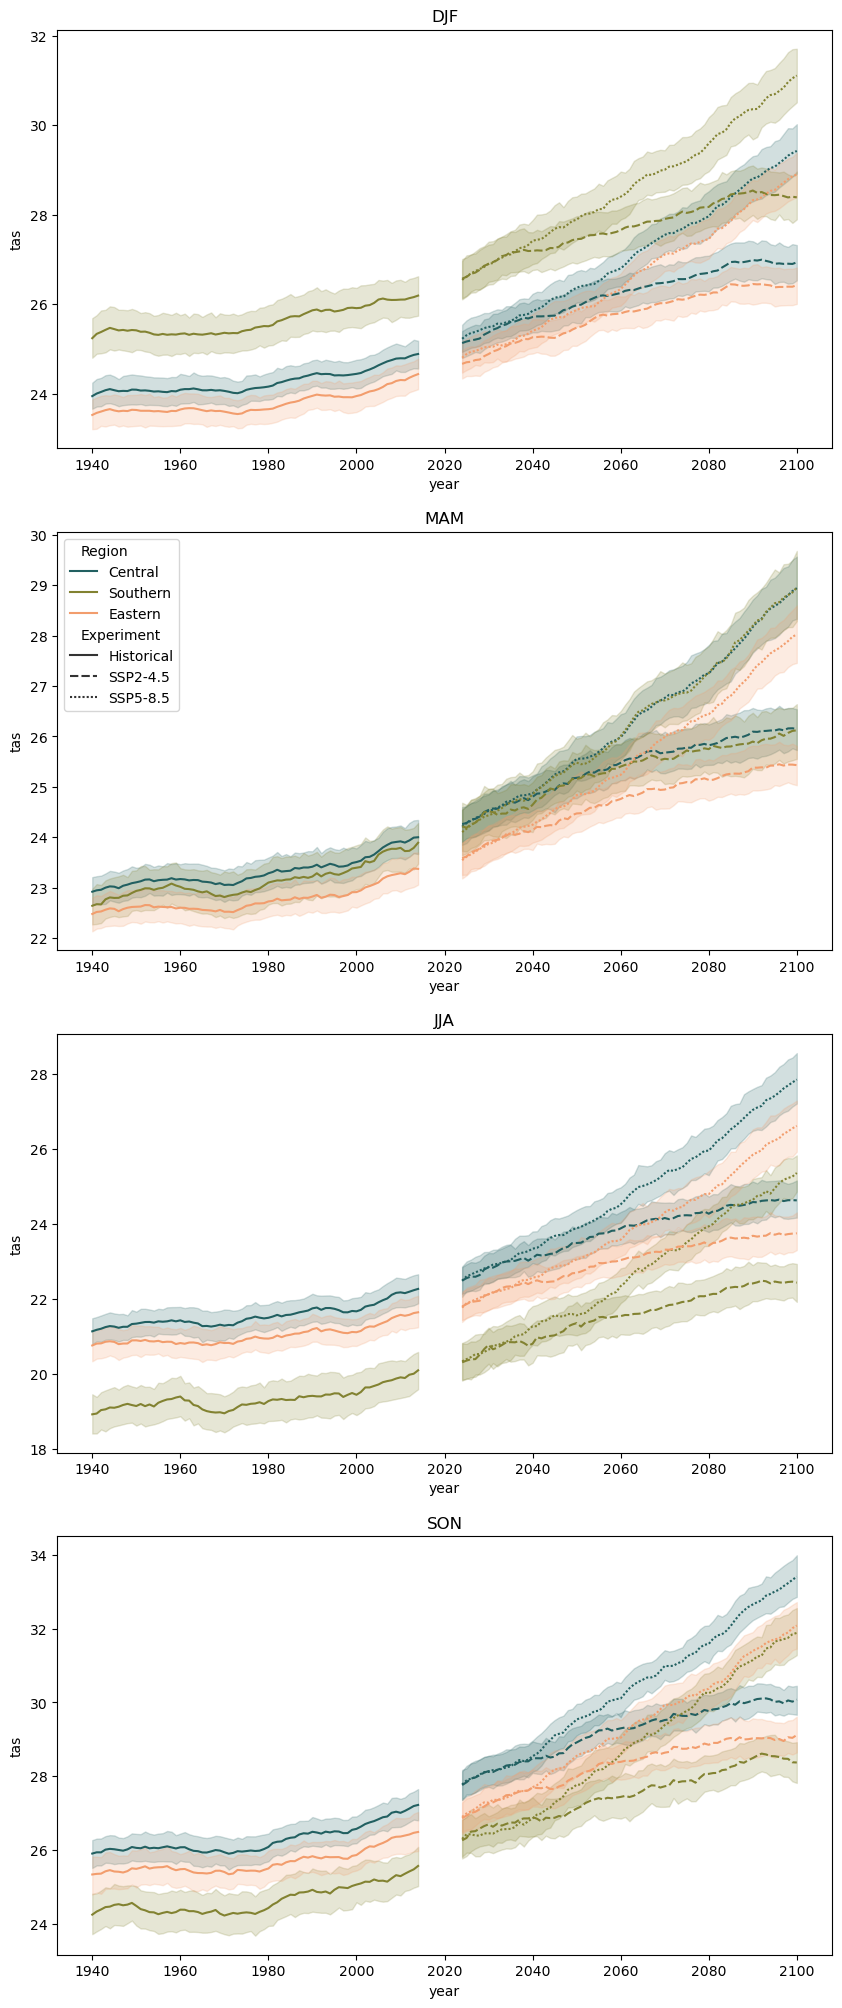

In [108]:
# plot time series for each season
fig, ax = plt.subplots(4,1, figsize=(10,25))
sns.lineplot(data=df_tas_season[df_tas_season['season']=='DJF'], x='year', y='tas', hue='Region', ax=ax[0], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_tas_season[df_tas_season['season']=='MAM'], x='year', y='tas', hue='Region', ax=ax[1], palette=palette, errorbar=('ci', 60), style='Experiment', legend=True)
sns.lineplot(data=df_tas_season[df_tas_season['season']=='JJA'], x='year', y='tas', hue='Region', ax=ax[2], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_tas_season[df_tas_season['season']=='SON'], x='year', y='tas', hue='Region', ax=ax[3], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
ax[0].title.set_text('DJF')
ax[1].title.set_text('MAM')
ax[2].title.set_text('JJA')
ax[3].title.set_text('SON')



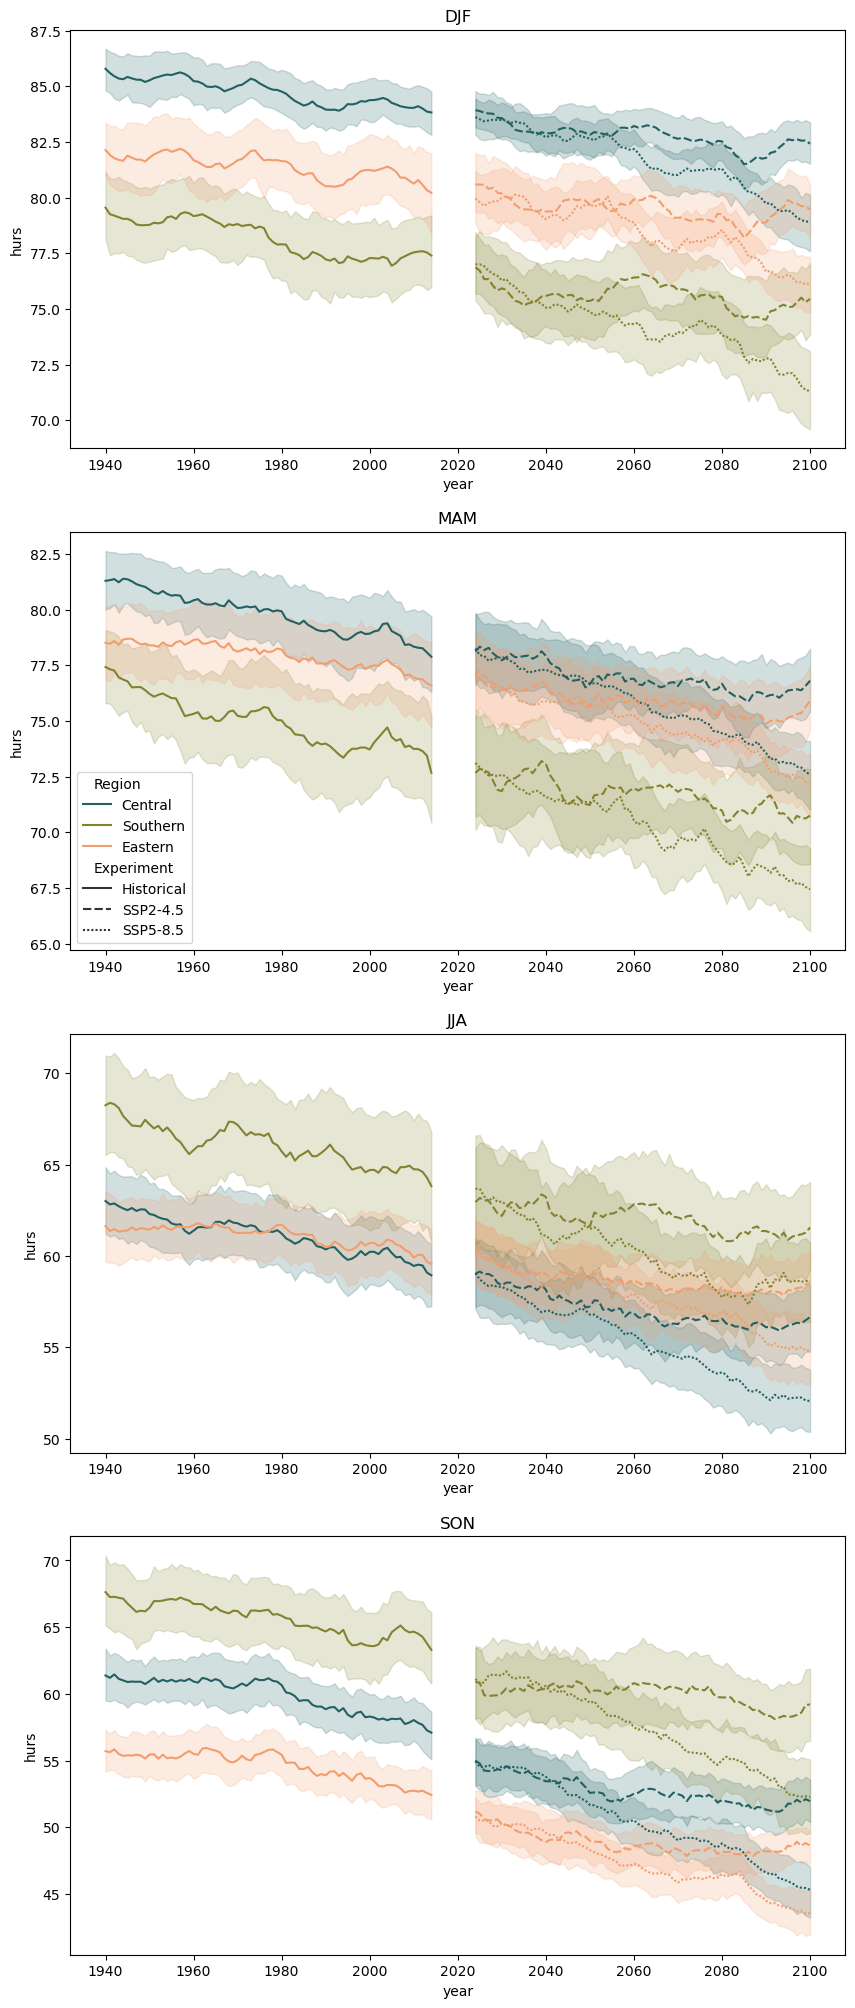

In [109]:
fig, ax = plt.subplots(4,1, figsize=(10,25))
sns.lineplot(data=df_hurs_season[df_hurs_season['season']=='DJF'], x='year', y='hurs', hue='Region', ax=ax[0], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_hurs_season[df_hurs_season['season']=='MAM'], x='year', y='hurs', hue='Region', ax=ax[1], palette=palette, errorbar=('ci', 60), style='Experiment', legend=True)
sns.lineplot(data=df_hurs_season[df_hurs_season['season']=='JJA'], x='year', y='hurs', hue='Region', ax=ax[2], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_hurs_season[df_hurs_season['season']=='SON'], x='year', y='hurs', hue='Region', ax=ax[3], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
ax[0].title.set_text('DJF')
ax[1].title.set_text('MAM')
ax[2].title.set_text('JJA')
ax[3].title.set_text('SON')


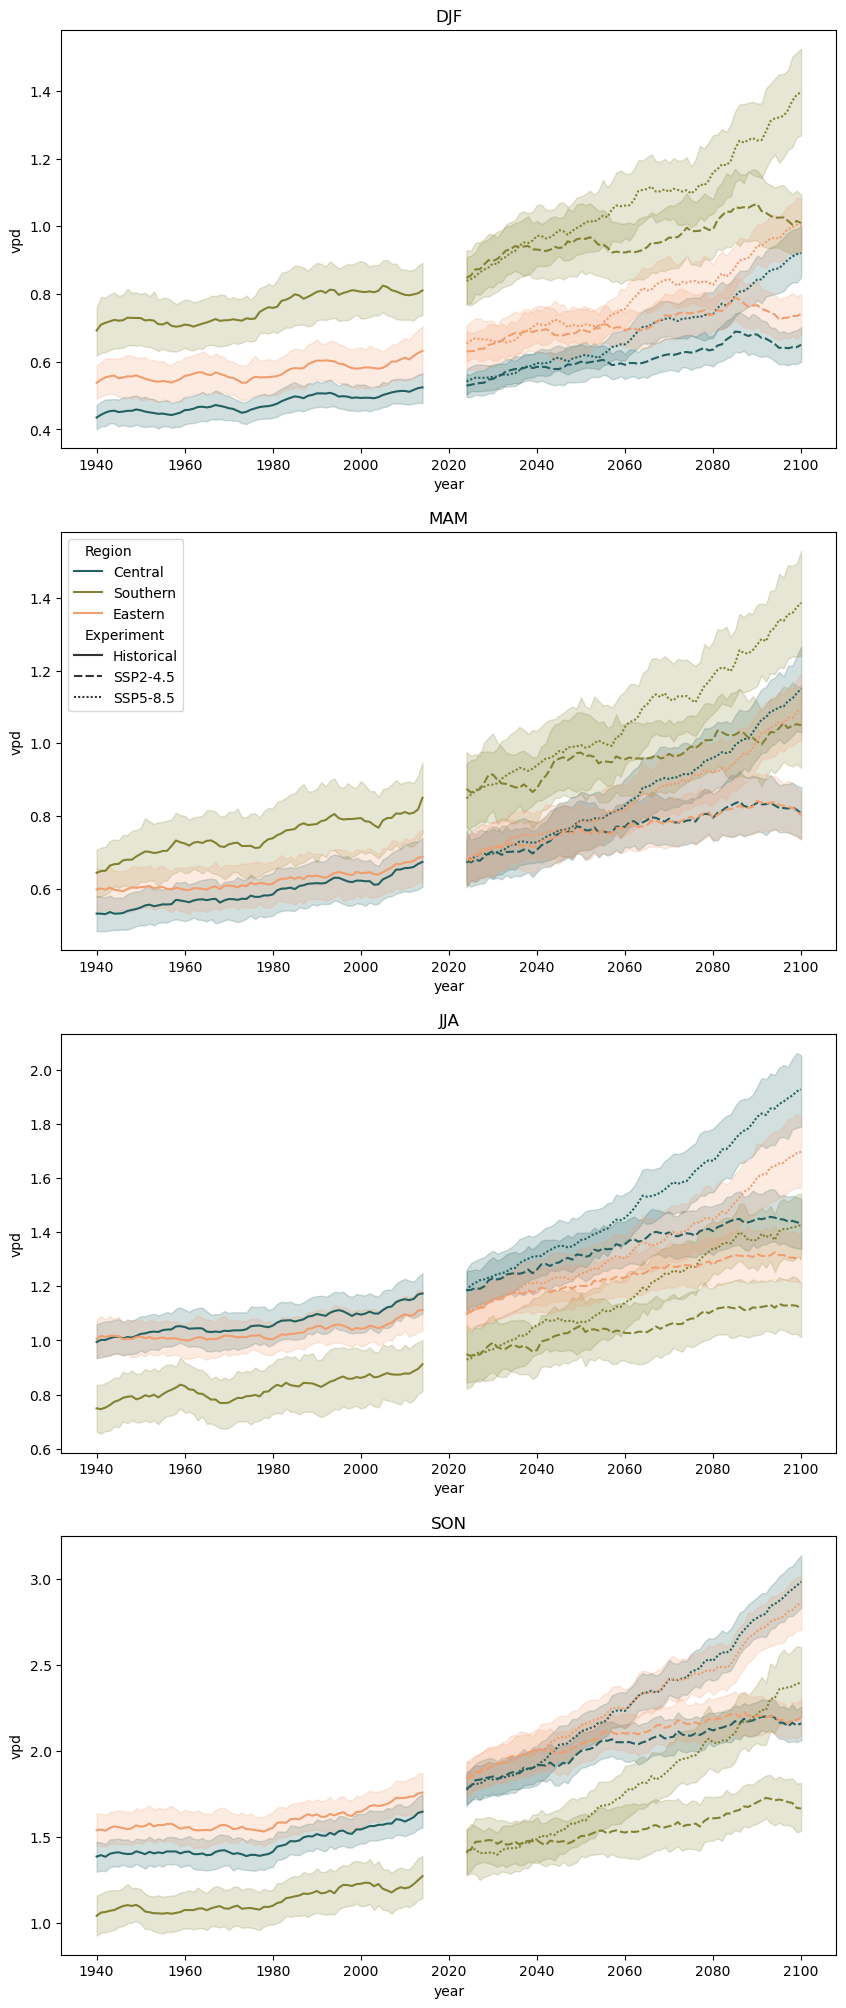

In [110]:
fig, ax = plt.subplots(4,1, figsize=(10,25))
sns.lineplot(data=df_vpd_season[df_vpd_season['season']=='DJF'], x='year', y='vpd', hue='Region', ax=ax[0], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_vpd_season[df_vpd_season['season']=='MAM'], x='year', y='vpd', hue='Region', ax=ax[1], palette=palette, errorbar=('ci', 60), style='Experiment', legend=True)
sns.lineplot(data=df_vpd_season[df_vpd_season['season']=='JJA'], x='year', y='vpd', hue='Region', ax=ax[2], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_vpd_season[df_vpd_season['season']=='SON'], x='year', y='vpd', hue='Region', ax=ax[3], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
ax[0].title.set_text('DJF')
ax[1].title.set_text('MAM')
ax[2].title.set_text('JJA')
ax[3].title.set_text('SON')


### anomaly

In [123]:
#get only data after 1940
df_pr_season_anom = df_pr_season_anom[df_pr_season_anom['year'] >= 1940]
df_tas_season_anom = df_tas_season_anom[df_tas_season_anom['year'] >= 1940]
df_hurs_season_anom = df_hurs_season_anom[df_hurs_season_anom['year'] >= 1940]
df_vpd_season_anom = df_vpd_season_anom[df_vpd_season_anom['year'] >= 1940]



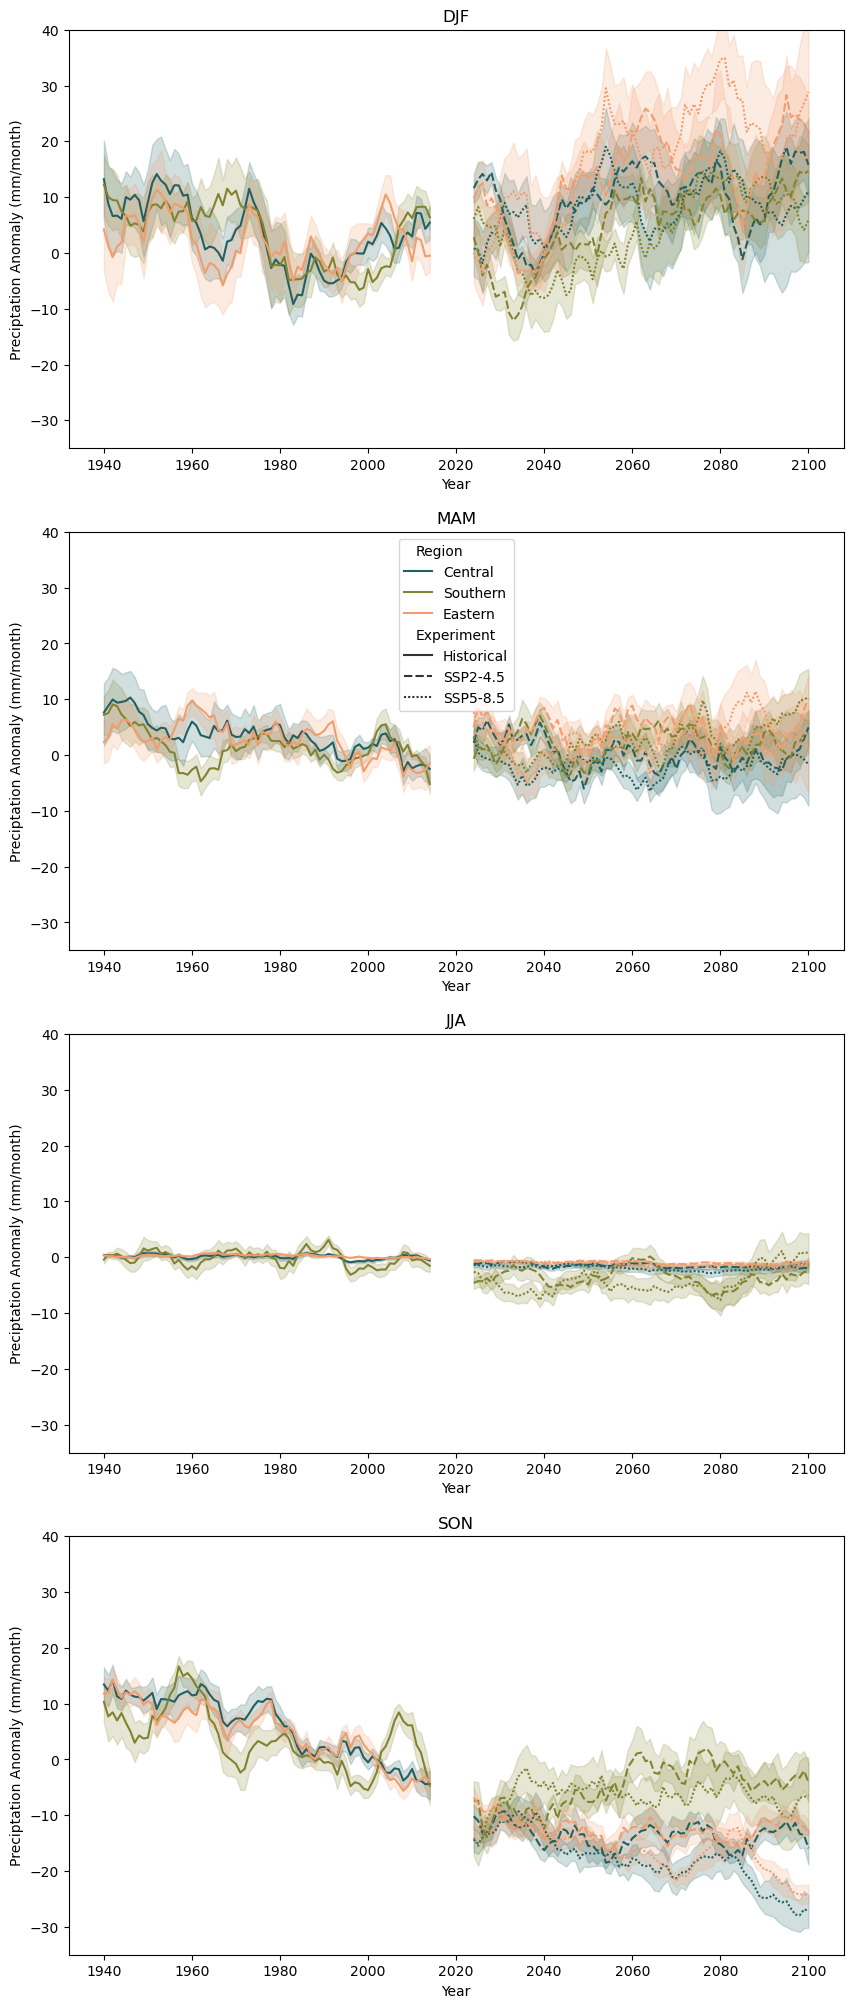

In [128]:
# plot time series for each season
fig, ax = plt.subplots(4,1, figsize=(10,25))
sns.lineplot(data=df_pr_season_anom[df_pr_season_anom['season']=='DJF'], x='year', y='pr', hue='Region', ax=ax[0], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_pr_season_anom[df_pr_season_anom['season']=='MAM'], x='year', y='pr', hue='Region', ax=ax[1], palette=palette, errorbar=('ci', 60), style='Experiment', legend=True)
sns.lineplot(data=df_pr_season_anom[df_pr_season_anom['season']=='JJA'], x='year', y='pr', hue='Region', ax=ax[2], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_pr_season_anom[df_pr_season_anom['season']=='SON'], x='year', y='pr', hue='Region', ax=ax[3], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
ax[0].title.set_text('DJF')
ax[1].title.set_text('MAM')
ax[2].title.set_text('JJA')
ax[3].title.set_text('SON')

# set ylim equal for all plots
for axis in ax:
    axis.set_ylim(-35, 40)
    axis.set_ylabel('Preciptation Anomaly (mm/month)')
    axis.set_xlabel('Year')

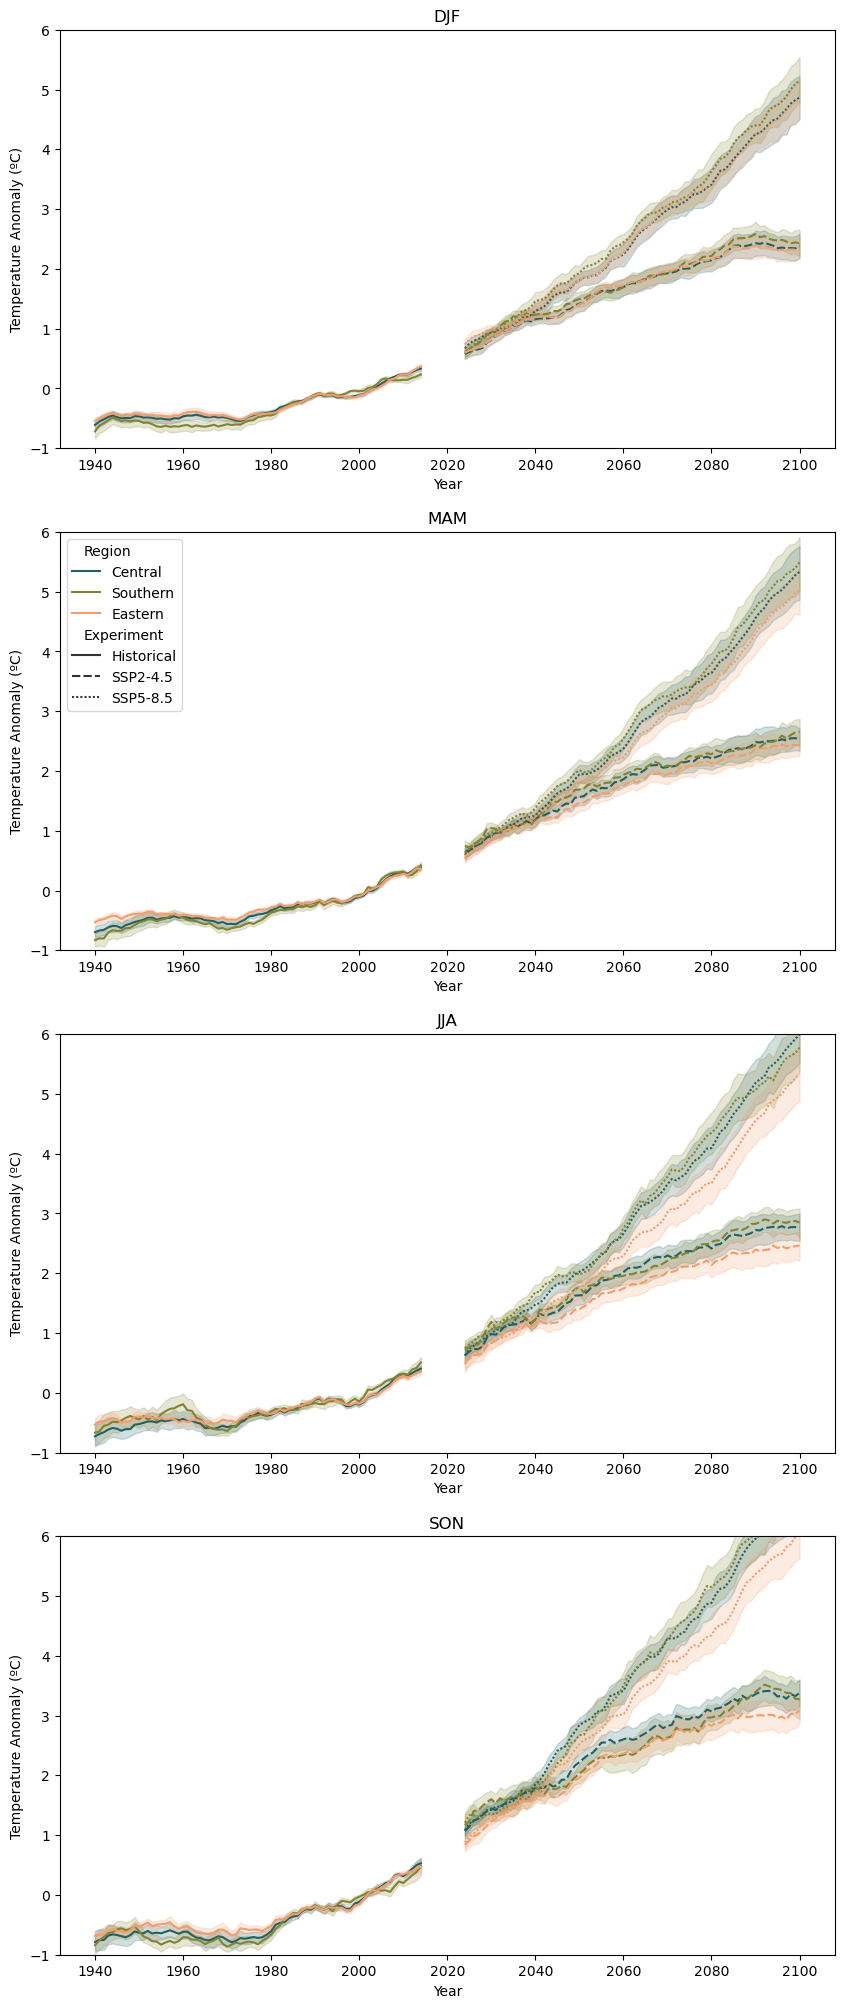

In [132]:
# plot time series for each season
fig, ax = plt.subplots(4,1, figsize=(10,25))
sns.lineplot(data=df_tas_season_anom[df_tas_season_anom['season']=='DJF'], x='year', y='tas', hue='Region', ax=ax[0], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_tas_season_anom[df_tas_season_anom['season']=='MAM'], x='year', y='tas', hue='Region', ax=ax[1], palette=palette, errorbar=('ci', 60), style='Experiment', legend=True)
sns.lineplot(data=df_tas_season_anom[df_tas_season_anom['season']=='JJA'], x='year', y='tas', hue='Region', ax=ax[2], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_tas_season_anom[df_tas_season_anom['season']=='SON'], x='year', y='tas', hue='Region', ax=ax[3], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
ax[0].title.set_text('DJF')
ax[1].title.set_text('MAM')
ax[2].title.set_text('JJA')
ax[3].title.set_text('SON')


# set ylim equal for all plots
for axis in ax:
    axis.set_ylim(-1, 6)
    axis.set_ylabel('Temperature Anomaly (ºC)')
    axis.set_xlabel('Year')


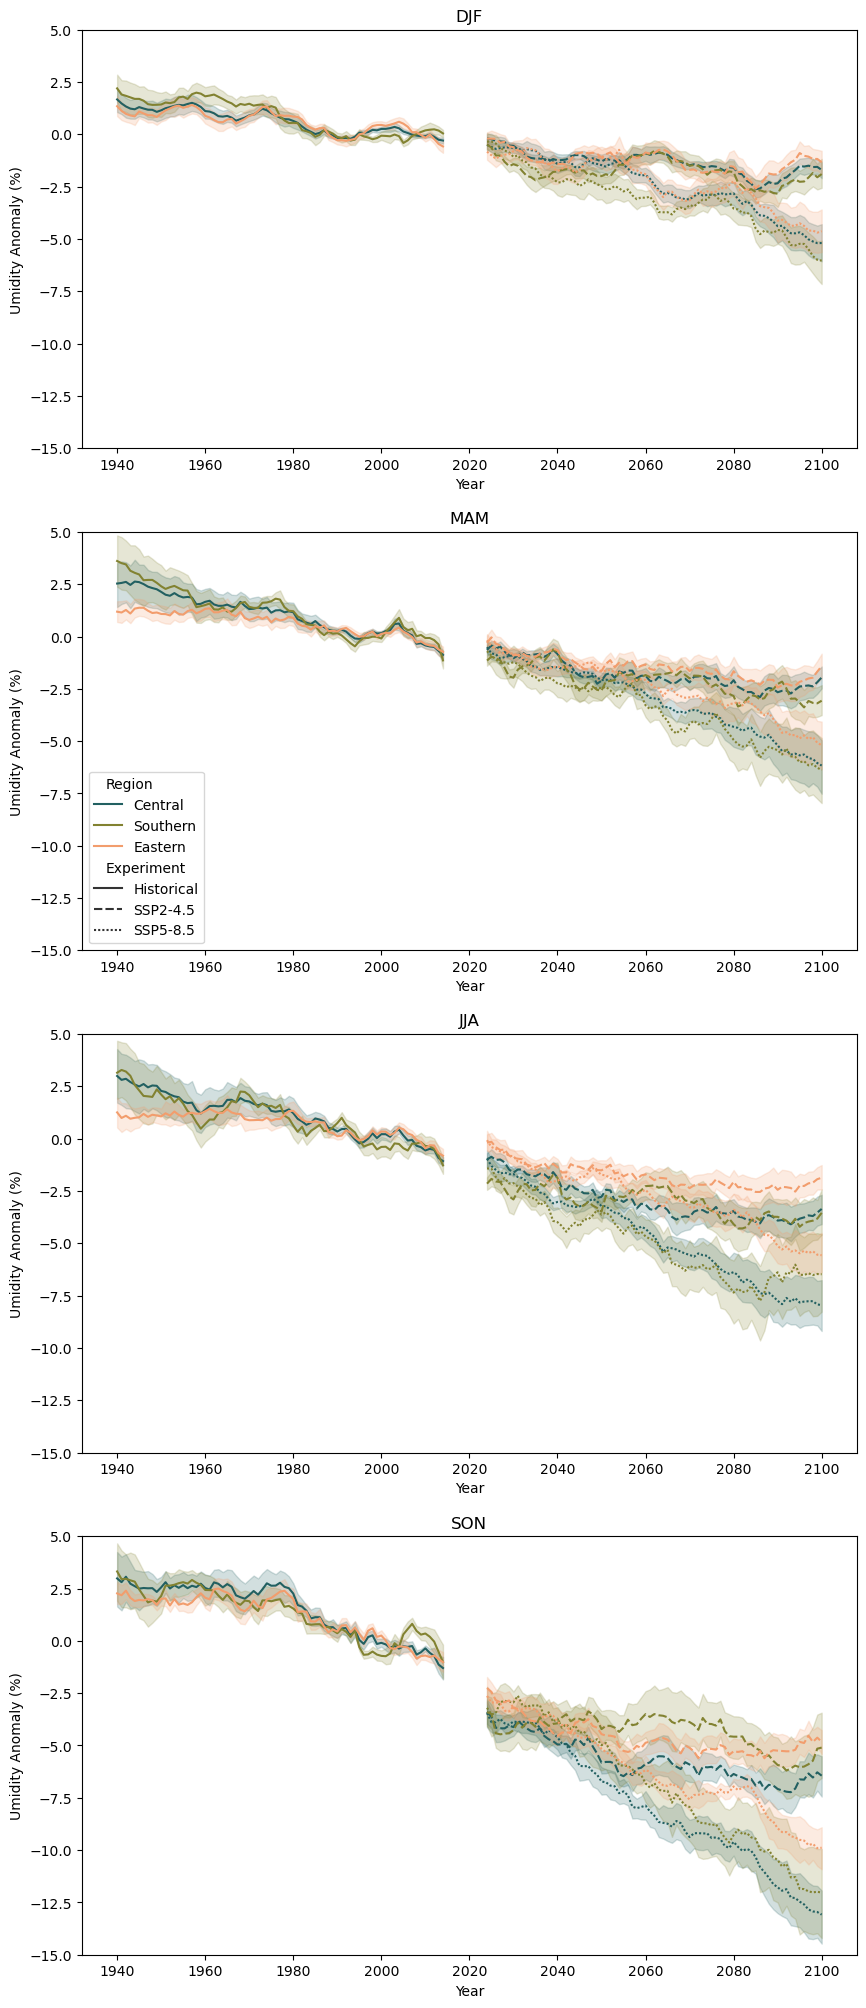

In [133]:
# plot time series for each season
fig, ax = plt.subplots(4,1, figsize=(10,25))
sns.lineplot(data=df_hurs_season_anom[df_hurs_season_anom['season']=='DJF'], x='year', y='hurs', hue='Region', ax=ax[0], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_hurs_season_anom[df_hurs_season_anom['season']=='MAM'], x='year', y='hurs', hue='Region', ax=ax[1], palette=palette, errorbar=('ci', 60), style='Experiment', legend=True)
sns.lineplot(data=df_hurs_season_anom[df_hurs_season_anom['season']=='JJA'], x='year', y='hurs', hue='Region', ax=ax[2], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_hurs_season_anom[df_hurs_season_anom['season']=='SON'], x='year', y='hurs', hue='Region', ax=ax[3], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
ax[0].title.set_text('DJF')
ax[1].title.set_text('MAM')
ax[2].title.set_text('JJA')
ax[3].title.set_text('SON')

# set ylim equal for all plots
for axis in ax:
    axis.set_ylim(-15, 5)
    axis.set_ylabel('Umidity Anomaly (%)')
    axis.set_xlabel('Year')


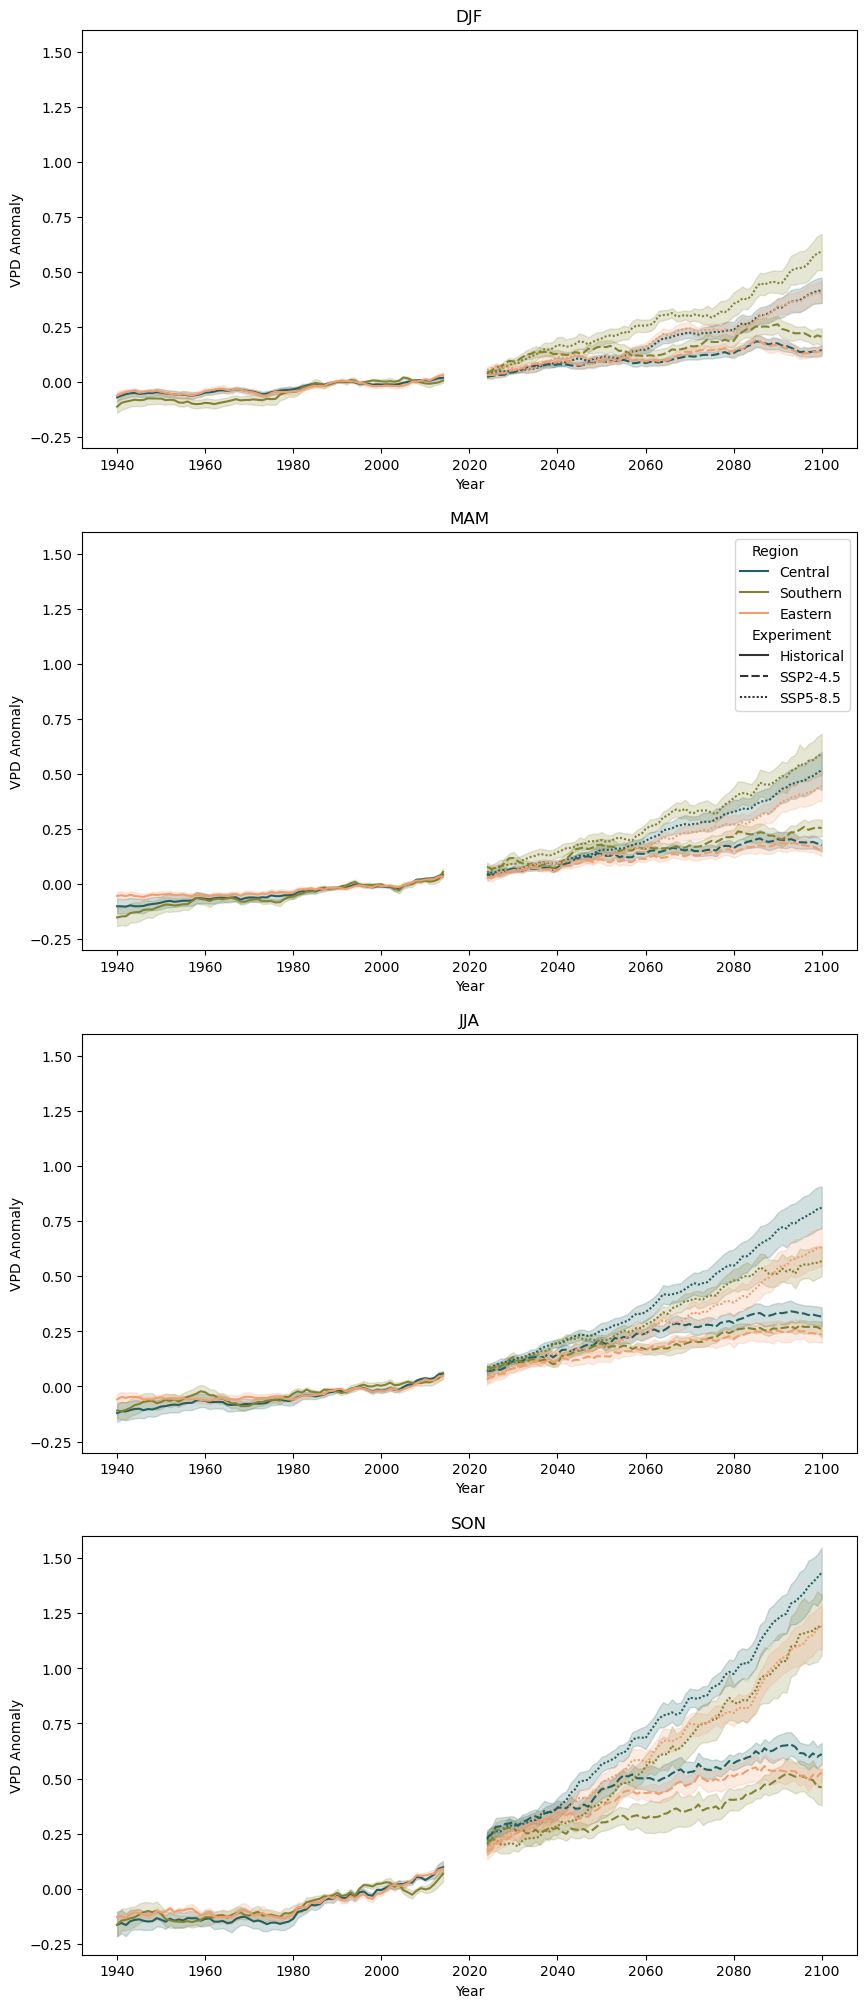

In [134]:
# plot time series for each season
fig, ax = plt.subplots(4,1, figsize=(10,25))
sns.lineplot(data=df_vpd_season_anom[df_vpd_season_anom['season']=='DJF'], x='year', y='vpd', hue='Region', ax=ax[0], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_vpd_season_anom[df_vpd_season_anom['season']=='MAM'], x='year', y='vpd', hue='Region', ax=ax[1], palette=palette, errorbar=('ci', 60), style='Experiment', legend=True)
sns.lineplot(data=df_vpd_season_anom[df_vpd_season_anom['season']=='JJA'], x='year', y='vpd', hue='Region', ax=ax[2], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_vpd_season_anom[df_vpd_season_anom['season']=='SON'], x='year', y='vpd', hue='Region', ax=ax[3], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
ax[0].title.set_text('DJF')
ax[1].title.set_text('MAM')
ax[2].title.set_text('JJA')
ax[3].title.set_text('SON')

# set ylim equal for all plots
for axis in ax:
    axis.set_ylim(-0.3, 1.6)
    axis.set_ylabel('VPD Anomaly')
    axis.set_xlabel('Year')



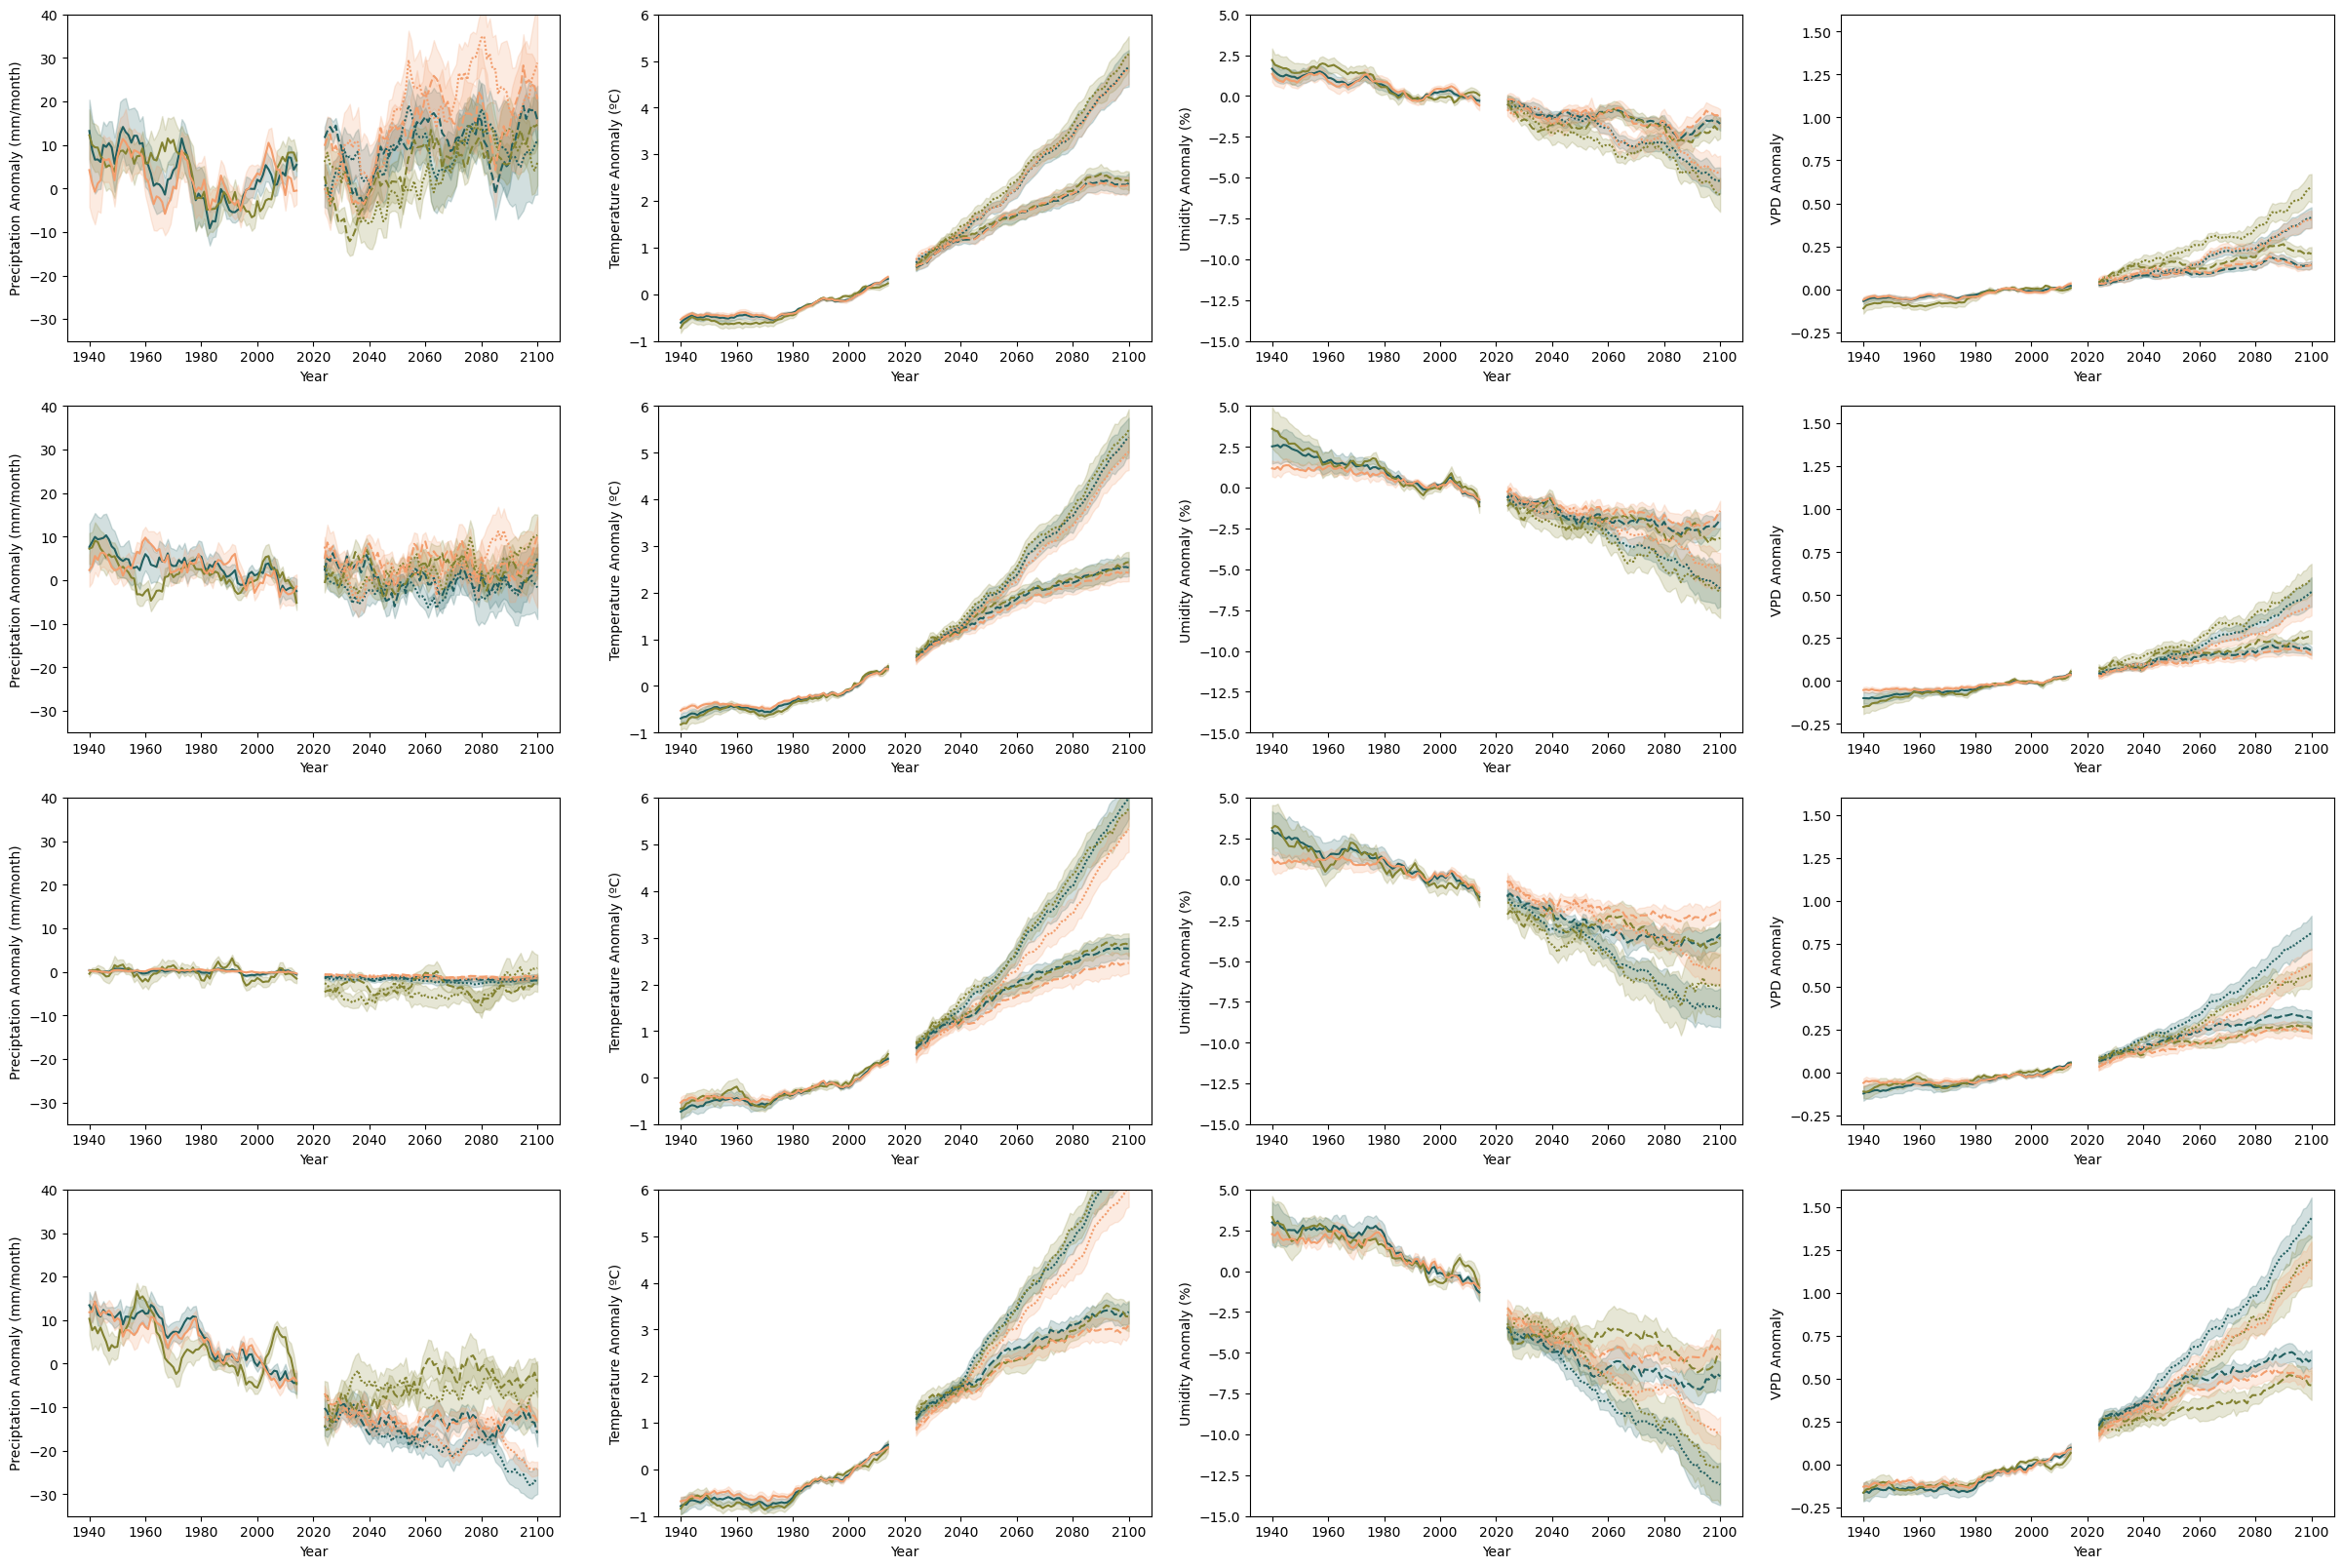

In [136]:
# plot all variables in one plot
fig, ax = plt.subplots(4,4, figsize=(30,20))
sns.lineplot(data=df_pr_season_anom[df_pr_season_anom['season']=='DJF'], x='year', y='pr', hue='Region', ax=ax[0,0], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_pr_season_anom[df_pr_season_anom['season']=='MAM'], x='year', y='pr', hue='Region', ax=ax[1,0], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_pr_season_anom[df_pr_season_anom['season']=='JJA'], x='year', y='pr', hue='Region', ax=ax[2,0], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_pr_season_anom[df_pr_season_anom['season']=='SON'], x='year', y='pr', hue='Region', ax=ax[3,0], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)

sns.lineplot(data=df_tas_season_anom[df_tas_season_anom['season']=='DJF'], x='year', y='tas', hue='Region', ax=ax[0,1], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_tas_season_anom[df_tas_season_anom['season']=='MAM'], x='year', y='tas', hue='Region', ax=ax[1,1], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_tas_season_anom[df_tas_season_anom['season']=='JJA'], x='year', y='tas', hue='Region', ax=ax[2,1], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_tas_season_anom[df_tas_season_anom['season']=='SON'], x='year', y='tas', hue='Region', ax=ax[3,1], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)

sns.lineplot(data=df_hurs_season_anom[df_hurs_season_anom['season']=='DJF'], x='year', y='hurs', hue='Region', ax=ax[0,2], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_hurs_season_anom[df_hurs_season_anom['season']=='MAM'], x='year', y='hurs', hue='Region', ax=ax[1,2], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_hurs_season_anom[df_hurs_season_anom['season']=='JJA'], x='year', y='hurs', hue='Region', ax=ax[2,2], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_hurs_season_anom[df_hurs_season_anom['season']=='SON'], x='year', y='hurs', hue='Region', ax=ax[3,2], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)

sns.lineplot(data=df_vpd_season_anom[df_vpd_season_anom['season']=='DJF'], x='year', y='vpd', hue='Region', ax=ax[0,3], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_vpd_season_anom[df_vpd_season_anom['season']=='MAM'], x='year', y='vpd', hue='Region', ax=ax[1,3], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_vpd_season_anom[df_vpd_season_anom['season']=='JJA'], x='year', y='vpd', hue='Region', ax=ax[2,3], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)
sns.lineplot(data=df_vpd_season_anom[df_vpd_season_anom['season']=='SON'], x='year', y='vpd', hue='Region', ax=ax[3,3], palette=palette, errorbar=('ci', 60), style='Experiment', legend=False)

#set ylim equal in same column
for axis in ax[:,0]:
    axis.set_ylim(-35, 40)
    axis.set_ylabel('Preciptation Anomaly (mm/month)')
    axis.set_xlabel('Year')


for axis in ax[:,1]:
    axis.set_ylim(-1, 6)
    axis.set_ylabel('Temperature Anomaly (ºC)')
    axis.set_xlabel('Year')


for axis in ax[:,2]:
    axis.set_ylim(-15, 5)
    axis.set_ylabel('Umidity Anomaly (%)')
    axis.set_xlabel('Year')

for axis in ax[:,3]:
    axis.set_ylim(-0.3, 1.6)
    axis.set_ylabel('VPD Anomaly')
    axis.set_xlabel('Year')        